In [1]:
import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import torch 
from sklearn.ensemble import StackingClassifier

import optuna
from optuna.samplers import TPESampler

In [2]:
def regplots(X, y):
    colors = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
    sns.set_palette(colors) # set custom color scheme

    labels = list(X.columns)
    
    N, p = X.shape

    rows = int(np.ceil(p/3)) 

    fig, axes = plt.subplots(rows, 5, figsize=(12, rows*(11/4)))

    for i, ax in enumerate(fig.axes):
        if i < p:          
            sns.regplot(X.iloc[:,i], y,  ci=None, logistic=True, y_jitter=0.05, 
                        scatter_kws={'s': 25, 'alpha':.5},  color=colors[i % 10], ax=ax)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.set_xticks([])
            ax.set_title(labels[i])
            ax.set_xlim(X.iloc[:,i].min(),X.iloc[:,i].max())
        else:
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()

    return fig, axes

def distplots(X, kde=True):

    labels = list(X.columns)
    
    N, p = X.shape

    rows = int(np.ceil(p/3)) 

    fig, axes = plt.subplots(rows, 3, figsize=(12, rows*(12/4)))

    for i, ax in enumerate(fig.axes):
        if i < p:
            sns.histplot(X.iloc[:,i], ax=ax, stat='density', kde=False, alpha= 0.9, edgecolor ='black')
            sns.kdeplot(X.iloc[:,i], ax=ax, alpha= 0.0, color='#333333')
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title(labels[i])
            ax.set_yticks([])
        else:
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

def crosstabplots(X, y,cols):
    colors = sns.color_palette() 

    labels = list(X.columns)
    
    N, p = X.shape

    rows = int(np.ceil(p/3)) 

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows*(12/4)))

    for i, ax in enumerate(fig.axes):
        if i < p:
            
            table=pd.crosstab(y, X.iloc[:,i])
            table = (table/table.sum()).iloc[1,:]
            (table.T).sort_index().plot(kind='bar', alpha=0.8, ax=ax, color=colors[i % len(colors)])
            
            ax.set_title(labels[i])
            ax.set_ylabel('')
            ax.set_xlabel('')
        else:
            fig.delaxes(ax)

    sns.despine()
    plt.tight_layout()
    
    return fig, axes

In [3]:
import warnings
warnings.filterwarnings('ignore') 
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F','#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [4]:
data1=pd.read_csv("store.csv")
data1.head()

,ZIP_CODE,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,1001,2,368.46,0,184.23,11,0.18,0.00,0.00,0.30,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,1028,4,258.00,1,64.50,11,0.26,0.16,0.00,0.00,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,1056,2,77.00,0,38.50,11,1.00,0.00,0.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,1118,8,846.06,1,105.75,11,0.38,0.00,0.05,0.06,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,1107,1,87.44,0,87.44,11,0.20,0.20,0.00,0.00,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


# DATA CLEANING

In [5]:
data1.isnull().sum()

ZIP_CODE        0
FRE             0
MON             0
CC_CARD         0
AVRG            0
PC_CALC20       0
PSWEATERS       0
PKNIT_TOPS      0
PKNIT_DRES      0
PBLOUSES        0
PJACKETS        0
PCAR_PNTS       0
PCAS_PNTS       0
PSHIRTS         0
PDRESSES        0
PSUITS          0
POUTERWEAR      0
PJEWELRY        0
PFASHION        0
PLEGWEAR        0
PCOLLSPND       0
AMSPEND         0
PSSPEND         0
CCSPEND         0
AXSPEND         0
TMONSPEND       0
OMONSPEND       0
SMONSPEND       0
PREVPD          0
GMP             0
PROMOS          0
DAYS            0
FREDAYS         0
MARKDOWN        0
CLASSES         0
COUPONS         0
STYLES          0
STORES          0
VALPHON         0
WEB             0
MAILED          0
RESPONDED       0
RESPONSERATE    0
HI              0
LTFREDAY        0
CLUSTYPE        0
PERCRET         0
RESP            0
dtype: int64

In [6]:
data1['VALPHON']=np.where(data1['VALPHON']=='Y',1,0).astype(int)

# TYPE INFERENCE

In [7]:
X1 = data1.drop(['RESP','ZIP_CODE'],axis=1)
continuous=[]
discrete=[]
binary=[]
for variable in X1.columns:
    if data1[variable].dtypes=='float64':
        continuous.append(variable)
    elif (data1[variable].dtypes=='int64') & (len(data1[variable].unique())>2):
        discrete.append(variable)
    else:
        binary.append(variable)

In [8]:
len(continuous)

32

In [9]:
data_type=pd.DataFrame('', columns=['continuous','continuous','discrete','binary'], index=range(1,17)) 
data_type.iloc[0:16,0]=continuous[:16]
data_type.iloc[0:16,1]=continuous[16:]
data_type.iloc[0:len(discrete),2]=discrete
data_type.iloc[0:len(binary),3]=binary
                       
data_type

,continuous,continuous,discrete,binary
1,MON,PCOLLSPND,FRE,CC_CARD
2,AVRG,AMSPEND,PC_CALC20,VALPHON
3,PSWEATERS,PSSPEND,PROMOS,WEB
4,PKNIT_TOPS,CCSPEND,DAYS,
5,PKNIT_DRES,AXSPEND,CLASSES,
6,PBLOUSES,TMONSPEND,COUPONS,
7,PJACKETS,OMONSPEND,STYLES,
8,PCAR_PNTS,SMONSPEND,STORES,
9,PCAS_PNTS,PREVPD,MAILED,
10,PSHIRTS,GMP,RESPONDED,


# DATA SPLITTING

In [10]:
from sklearn.model_selection import train_test_split

index_train, index_valid_test = train_test_split(np.array(data1.index), stratify=data1[['RESP']], 
                                            train_size=0.8, random_state=19082000)
training1 = data1.loc[index_train,:]
validation_test1 = data1.loc[index_valid_test,:]

# OUTLIER ANALYSIS

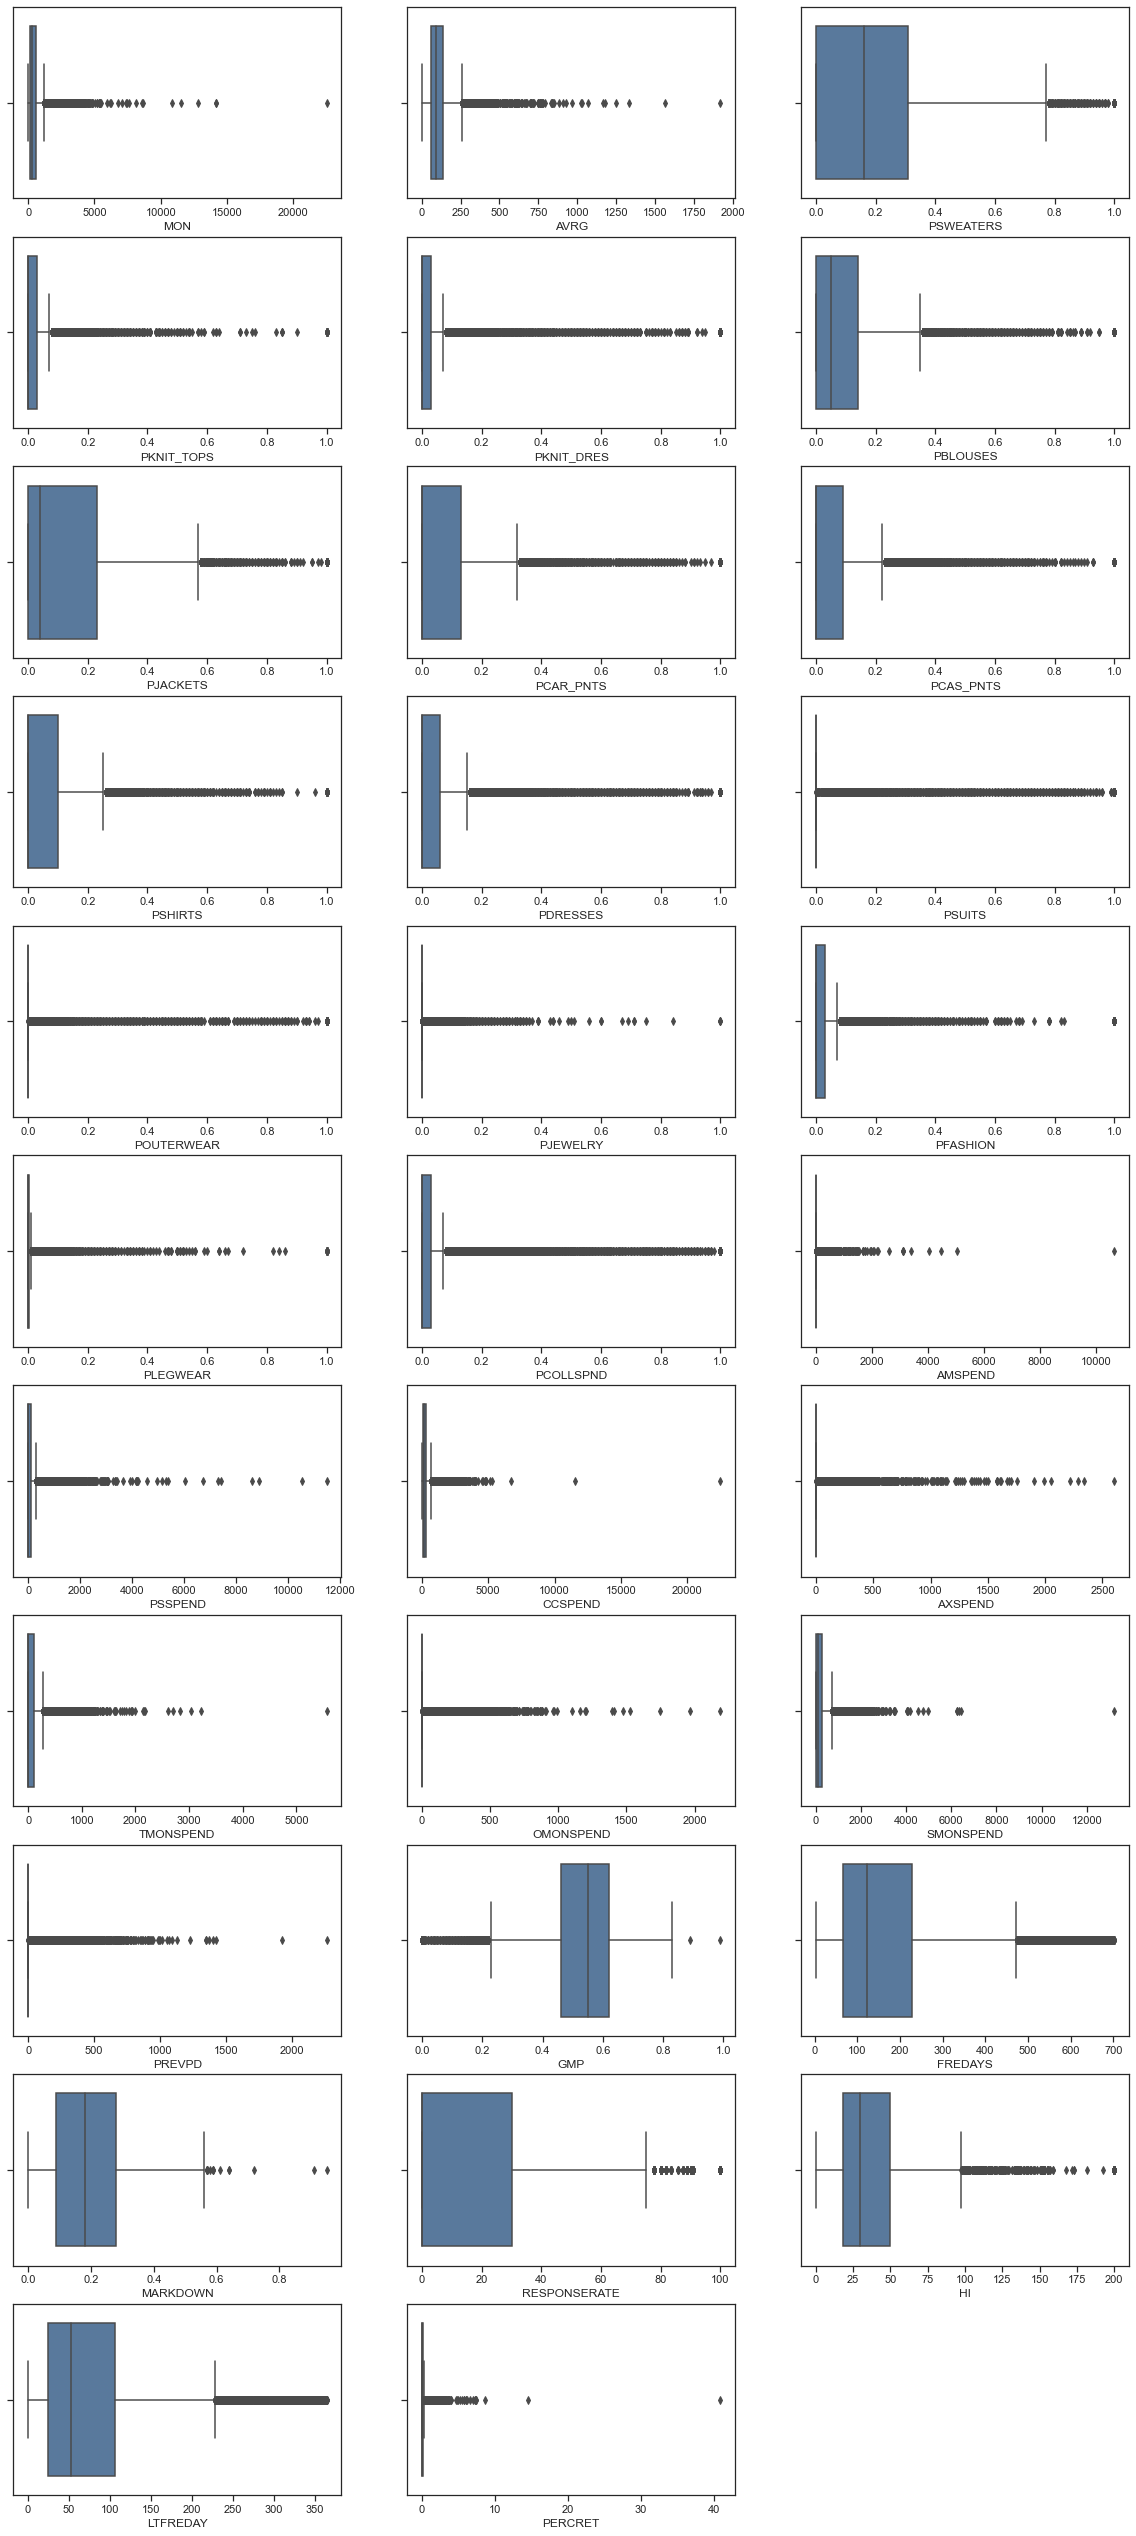

In [11]:
fig = plt.figure(figsize=(20,50))
for count in range(len(continuous)):
    sns.boxplot(continuous[count], data=training1,ax=fig.add_subplot(12,3,count+1))
    count=count+1


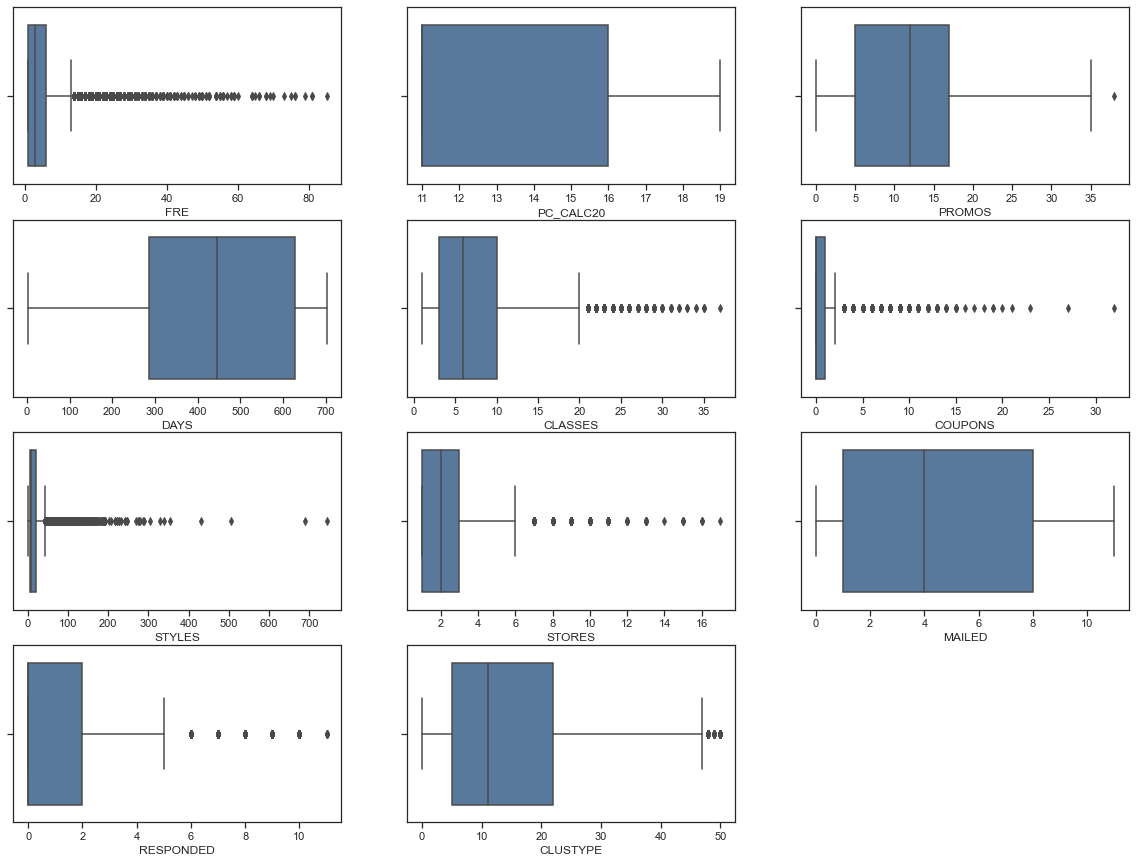

In [12]:
fig = plt.figure(figsize=(20,15))
for count in range(11):
    sns.boxplot(discrete[count], data=training1,ax=fig.add_subplot(4,3,count+1))
    count=count+1


# RESPONSE VARIABLE

<AxesSubplot:xlabel='RESP', ylabel='count'>

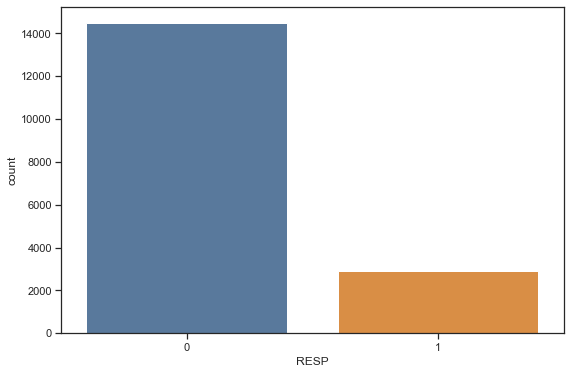

In [13]:
sns.countplot(training1['RESP'])


In [14]:
proportion1 = round(sum(training1['RESP'])/len(training1['RESP']),3)
proportion0 = 1 - proportion1
print('The proportion of responsive customers is {}'.format(proportion1))
print('The proportion of nonresponsive customers is {}'.format(proportion0))

The proportion of responsive customers is 0.166
The proportion of nonresponsive customers is 0.834


# CONTINUOUS & DISCRETE VARIABLES

<AxesSubplot:>

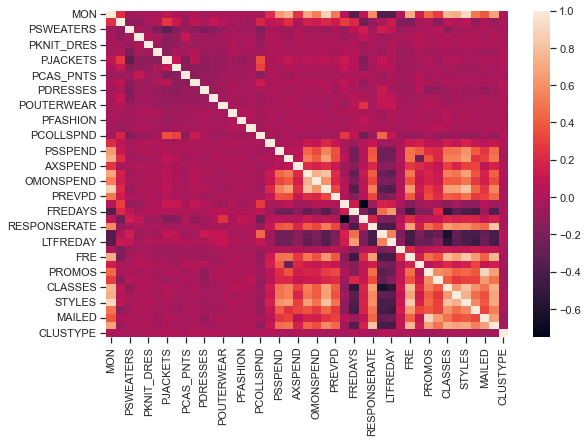

In [15]:
sns.heatmap(training1[continuous+discrete].corr())

In [16]:
training1[continuous[:16]].describe().round(3)

,MON,AVRG,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,PBLOUSES,PJACKETS,PCAR_PNTS,PCAS_PNTS,PSHIRTS,PDRESSES,PSUITS,POUTERWEAR,PJEWELRY,PFASHION,PLEGWEAR
count,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000
mean,471.958,113.929,0.212,0.027,0.041,0.094,0.136,0.086,0.069,0.066,0.068,0.034,0.019,0.010,0.030,0.013
std,640.617,88.465,0.229,0.069,0.110,0.137,0.183,0.140,0.133,0.116,0.157,0.130,0.102,0.037,0.079,0.050
min,1.990,1.990,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,136.360,60.990,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,263.010,91.845,0.160,0.000,0.000,0.050,0.040,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,567.792,139.500,0.310,0.030,0.030,0.140,0.230,0.130,0.090,0.100,0.060,0.000,0.000,0.000,0.030,0.004
max,22511.490,1919.880,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [17]:
training1[continuous[16:]].describe().round(3)

,PCOLLSPND,AMSPEND,PSSPEND,CCSPEND,AXSPEND,TMONSPEND,OMONSPEND,SMONSPEND,PREVPD,GMP,FREDAYS,MARKDOWN,RESPONSERATE,HI,LTFREDAY,PERCRET
count,17392.000,17392.000,17392.000,17392.000,17392.000,17392.00,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000
mean,0.073,13.552,147.234,287.408,24.039,90.04,31.996,222.005,41.504,0.522,170.043,0.188,17.272,37.823,79.707,0.127
std,0.174,148.321,389.781,448.120,111.009,186.43,98.583,364.268,108.192,0.143,145.375,0.129,24.571,28.029,77.939,0.489
min,0.000,0.000,0.000,0.010,0.000,0.00,0.000,0.000,0.000,0.000,2.750,0.000,0.000,0.050,0.090,0.000
25%,0.000,0.000,0.000,78.000,0.000,0.00,0.000,0.000,0.000,0.460,67.000,0.090,0.000,18.438,24.910,0.000
50%,0.000,0.000,0.000,147.990,0.000,0.00,0.000,108.000,0.000,0.550,123.290,0.180,0.000,29.510,52.100,0.000
75%,0.030,0.000,126.992,320.982,0.000,109.45,0.000,286.942,0.000,0.620,229.000,0.280,30.000,50.000,106.000,0.090
max,1.000,10642.720,11476.800,22511.490,2602.960,5562.46,2189.000,13224.070,2259.500,0.990,702.000,0.950,100.000,200.000,364.000,40.920


In [18]:
from scipy.stats import skew
from scipy.stats import kurtosis
continuous_skewness = skew(training1[continuous],axis=0)
continuous_kurtosis = kurtosis(training1[continuous],axis=0)

pd.DataFrame({'Skewness': continuous_skewness,'Kurtosis': continuous_kurtosis} , index=continuous)

,Skewness,Kurtosis
MON,7.279759,137.413740
AVRG,3.739644,32.083163
PSWEATERS,1.496871,2.231835
PKNIT_TOPS,6.224722,61.494573
PKNIT_DRES,4.493538,25.749757
PBLOUSES,2.693375,10.611110
PJACKETS,1.563927,2.561252
PCAR_PNTS,2.420737,7.737642
PCAS_PNTS,3.044526,12.003130
PSHIRTS,2.887088,12.010251


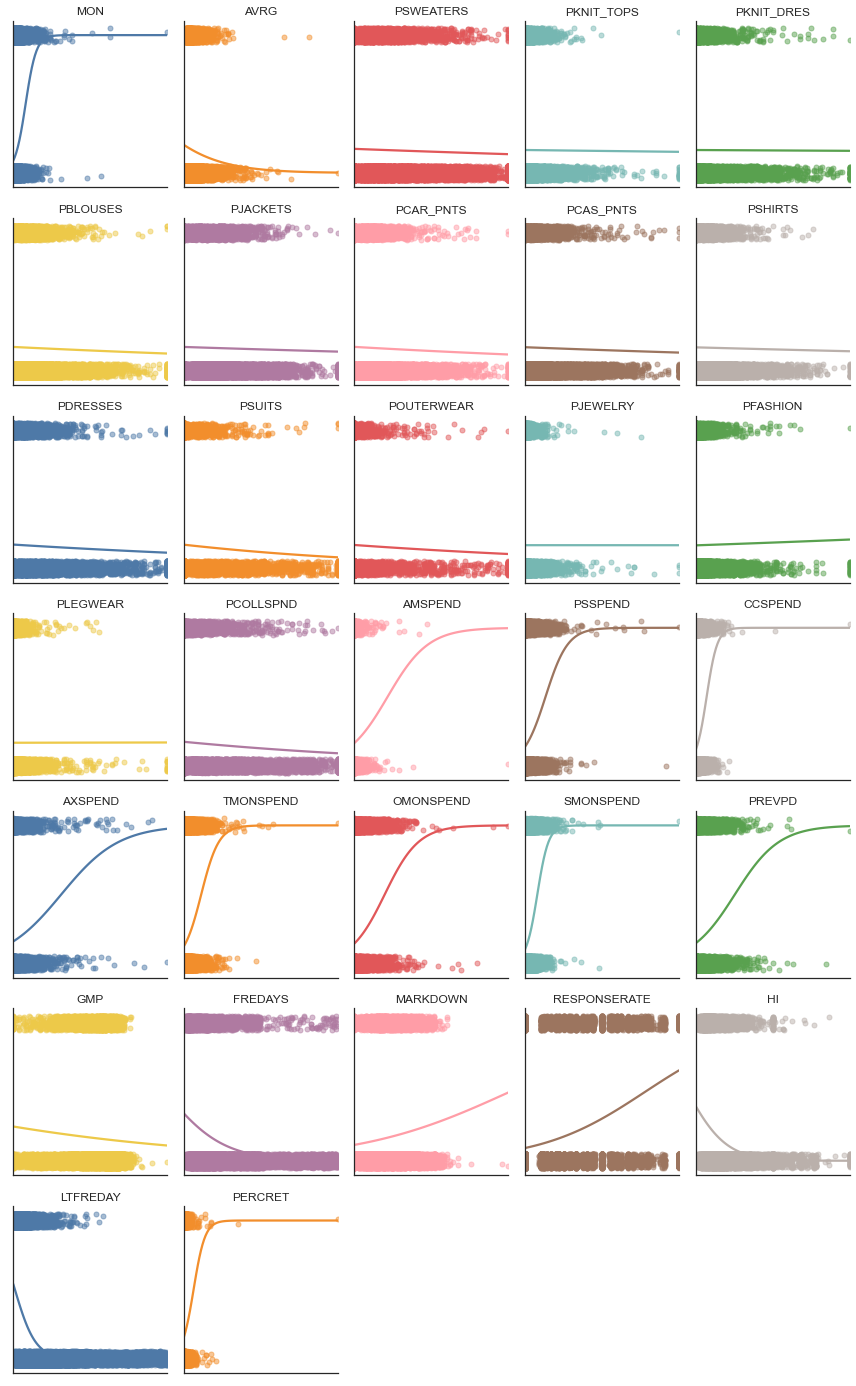

In [19]:
fig, ax = regplots(training1[continuous], training1['RESP'])
plt.show()

(<Figure size 864x2376 with 32 Axes>,
 array([[<AxesSubplot:title={'center':'MON'}>,
         <AxesSubplot:title={'center':'AVRG'}>,
         <AxesSubplot:title={'center':'PSWEATERS'}>],
        [<AxesSubplot:title={'center':'PKNIT_TOPS'}>,
         <AxesSubplot:title={'center':'PKNIT_DRES'}>,
         <AxesSubplot:title={'center':'PBLOUSES'}>],
        [<AxesSubplot:title={'center':'PJACKETS'}>,
         <AxesSubplot:title={'center':'PCAR_PNTS'}>,
         <AxesSubplot:title={'center':'PCAS_PNTS'}>],
        [<AxesSubplot:title={'center':'PSHIRTS'}>,
         <AxesSubplot:title={'center':'PDRESSES'}>,
         <AxesSubplot:title={'center':'PSUITS'}>],
        [<AxesSubplot:title={'center':'POUTERWEAR'}>,
         <AxesSubplot:title={'center':'PJEWELRY'}>,
         <AxesSubplot:title={'center':'PFASHION'}>],
        [<AxesSubplot:title={'center':'PLEGWEAR'}>,
         <AxesSubplot:title={'center':'PCOLLSPND'}>,
         <AxesSubplot:title={'center':'AMSPEND'}>],
        [<AxesSubplot:t

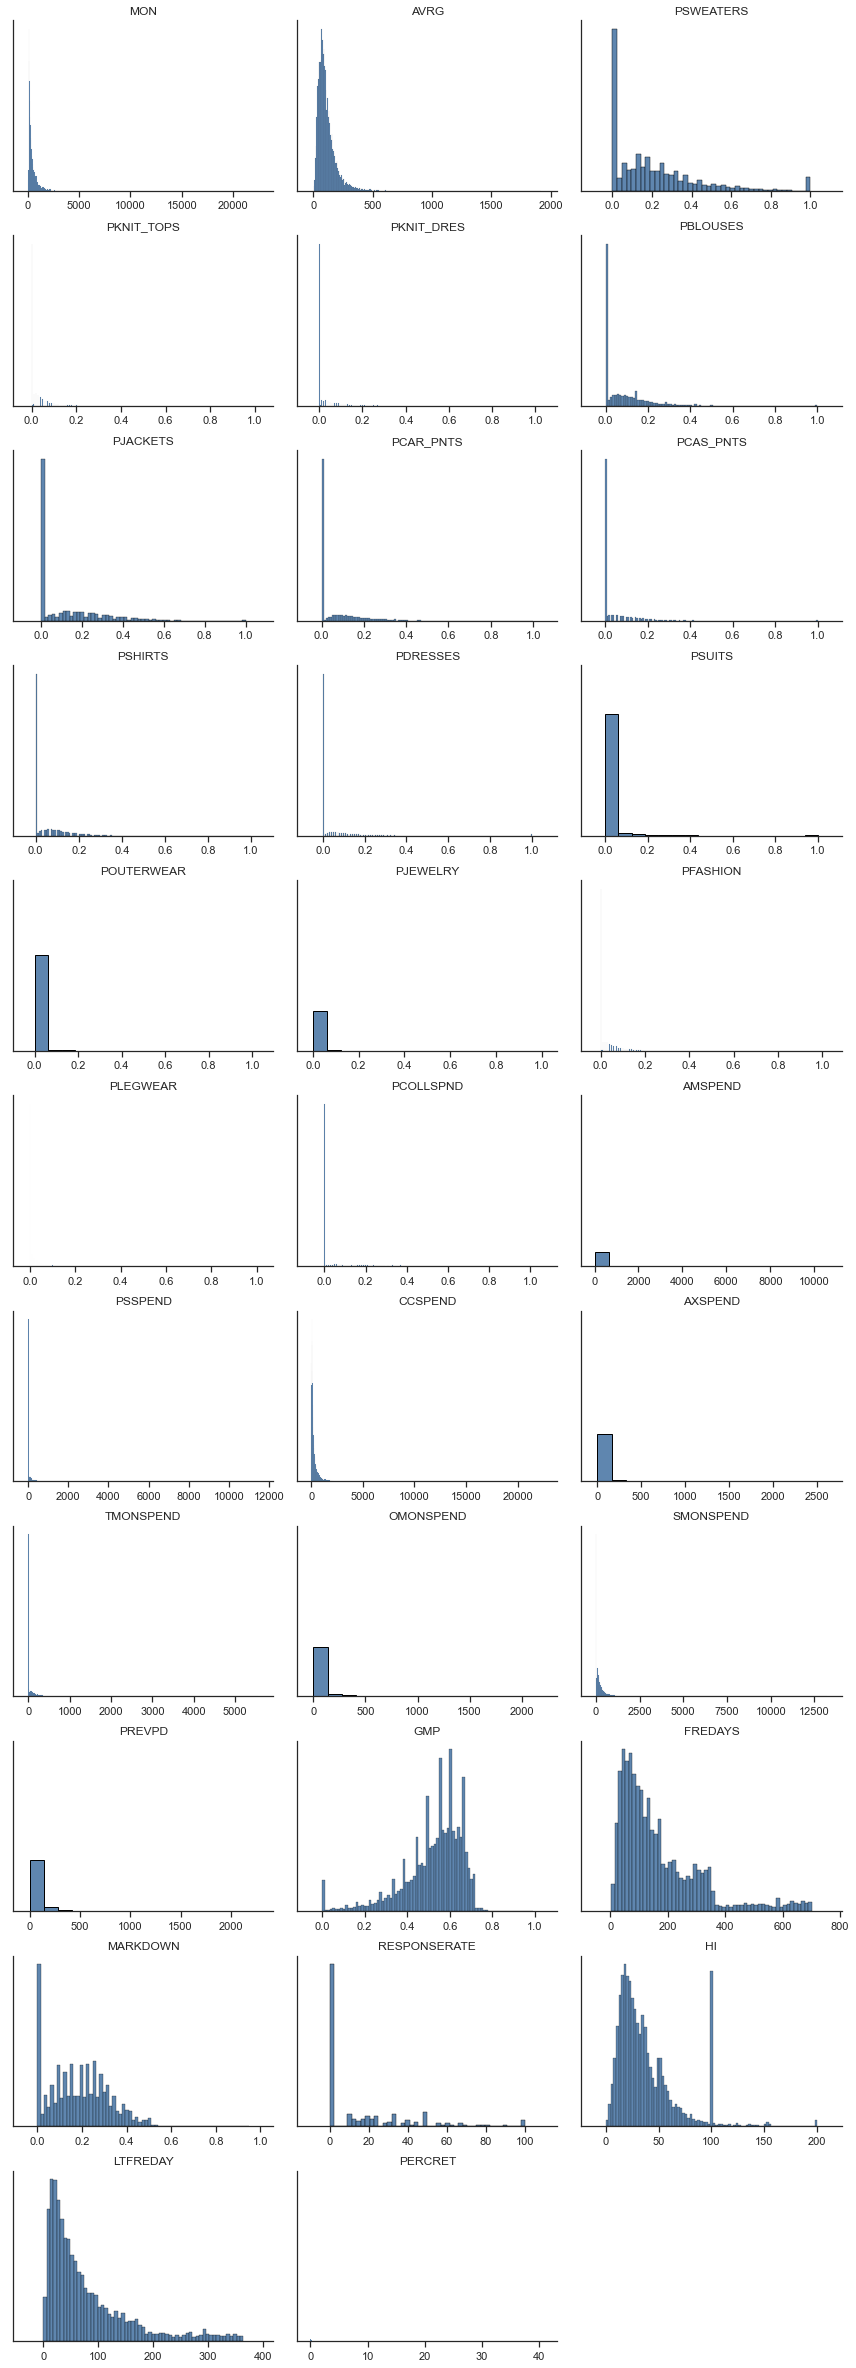

In [20]:
distplots(training1[continuous])

In [21]:
mi_continuous = mutual_info_classif(training1[continuous],training1['RESP'], random_state=1)
pd.DataFrame({'Mutual Information': mi_continuous} , index=continuous).sort_values(by='Mutual Information', ascending=False).head(32).round(3)

,Mutual Information
LTFREDAY,0.110
FREDAYS,0.064
MON,0.053
SMONSPEND,0.050
RESPONSERATE,0.049
HI,0.042
TMONSPEND,0.035
CCSPEND,0.034
PBLOUSES,0.031
PDRESSES,0.031


In [22]:
training1[discrete].describe().round(3)

,FRE,PC_CALC20,PROMOS,DAYS,CLASSES,COUPONS,STYLES,STORES,MAILED,RESPONDED,CLUSTYPE
count,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000,17392.000
mean,5.047,12.568,11.558,436.705,7.147,0.742,17.146,2.333,4.652,1.186,15.177
std,6.347,2.462,7.146,193.319,5.338,1.652,24.537,1.589,3.547,1.819,12.254
min,1.000,11.000,0.000,3.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000
25%,1.000,11.000,5.000,286.000,3.000,0.000,5.000,1.000,1.000,0.000,5.000
50%,3.000,11.000,12.000,445.500,6.000,0.000,9.000,2.000,4.000,0.000,11.000
75%,6.000,16.000,17.000,629.000,10.000,1.000,20.000,3.000,8.000,2.000,22.000
max,85.000,19.000,38.000,702.000,37.000,32.000,743.000,17.000,11.000,11.000,50.000


In [23]:
skew(training1[discrete],axis=0)

array([ 4.00073601,  1.03858601,  0.15238605, -0.23694349,  1.29703599,
        4.37173188,  6.73762194,  2.19021499,  0.15086174,  1.96683435,
        1.02262326])

In [24]:
kurtosis(training1[discrete],axis=0)

array([ 25.42392321,  -0.62530565,  -0.91598764,  -1.16567562,
         1.61790792,  32.02692743, 110.86427148,   7.78893661,
        -1.4161167 ,   3.99581123,   0.23545049])

In [25]:
discrete_skewness = skew(training1[discrete],axis=0)
discrete_kurtosis = kurtosis(training1[discrete],axis=0)

pd.DataFrame({'Skewness': discrete_skewness,'Kurtosis': discrete_kurtosis} , index=discrete)

,Skewness,Kurtosis
FRE,4.000736,25.423923
PC_CALC20,1.038586,-0.625306
PROMOS,0.152386,-0.915988
DAYS,-0.236943,-1.165676
CLASSES,1.297036,1.617908
COUPONS,4.371732,32.026927
STYLES,6.737622,110.864271
STORES,2.190215,7.788937
MAILED,0.150862,-1.416117
RESPONDED,1.966834,3.995811


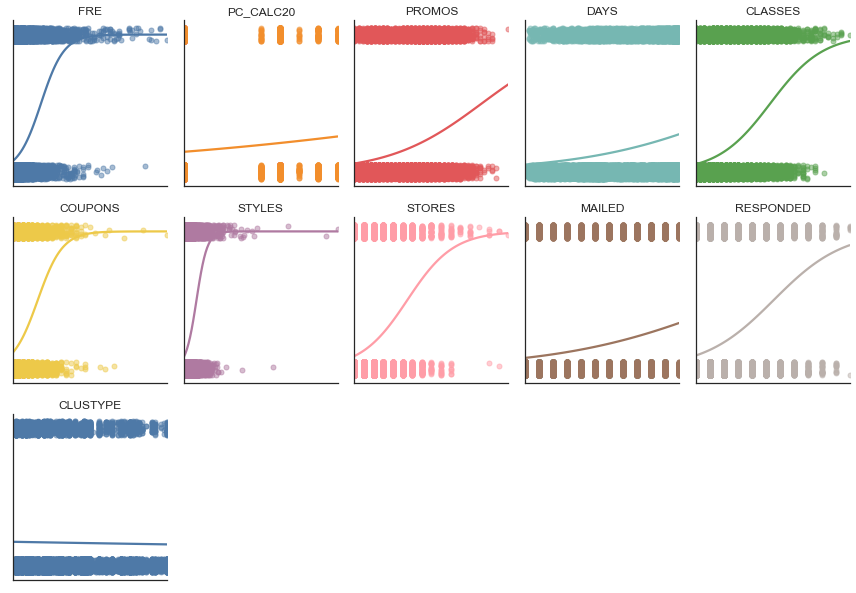

In [26]:
fig, ax = regplots(training1[discrete], training1['RESP'])
plt.show()

(<Figure size 864x864 with 11 Axes>,
 array([[<AxesSubplot:title={'center':'FRE'}>,
         <AxesSubplot:title={'center':'PC_CALC20'}>,
         <AxesSubplot:title={'center':'PROMOS'}>],
        [<AxesSubplot:title={'center':'DAYS'}>,
         <AxesSubplot:title={'center':'CLASSES'}>,
         <AxesSubplot:title={'center':'COUPONS'}>],
        [<AxesSubplot:title={'center':'STYLES'}>,
         <AxesSubplot:title={'center':'STORES'}>,
         <AxesSubplot:title={'center':'MAILED'}>],
        [<AxesSubplot:title={'center':'RESPONDED'}>,
         <AxesSubplot:title={'center':'CLUSTYPE'}>, <AxesSubplot:>]],
       dtype=object))

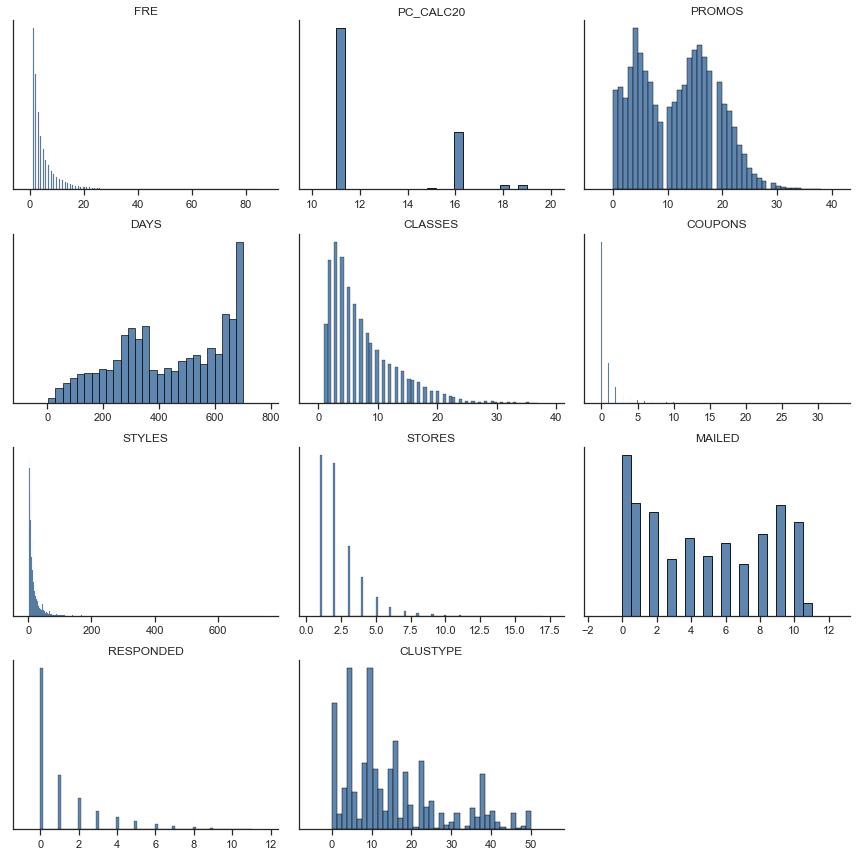

In [27]:
distplots(training1[discrete])

In [28]:
mi_discrete = mutual_info_classif(training1[discrete],training1['RESP'], n_neighbors=5, 
                         random_state=1, discrete_features=True)

pd.DataFrame({'Mutual Information': mi_discrete} , index=discrete).sort_values(by='Mutual Information', ascending=False).round(3)

,Mutual Information
FRE,0.081
STYLES,0.076
CLASSES,0.062
RESPONDED,0.052
COUPONS,0.044
DAYS,0.043
STORES,0.040
PROMOS,0.027
MAILED,0.023
PC_CALC20,0.004


In [ ]:
sns.countplot(training1['RESPONDED'])

# BINARY VARIABLES

In [29]:
training1[binary].describe().round(3)

,CC_CARD,VALPHON,WEB
count,17392.000,17392.000,17392.000
mean,0.384,0.861,0.042
std,0.486,0.346,0.202
min,0.000,0.000,0.000
25%,0.000,1.000,0.000
50%,0.000,1.000,0.000
75%,1.000,1.000,0.000
max,1.000,1.000,1.000


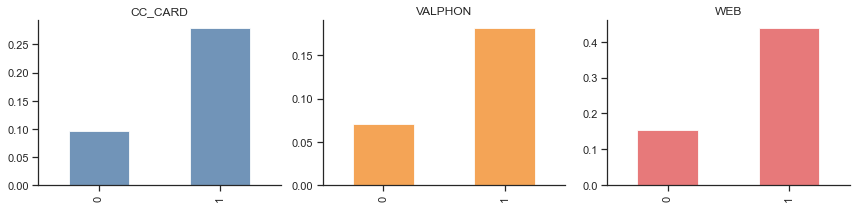

In [30]:
crosstabplots(training1[binary], training1['RESP'],cols=3)
plt.show()

In [31]:
mi_binary = mutual_info_classif(training1[binary],training1['RESP'], n_neighbors=10, 
                         random_state=1, discrete_features=True)

pd.DataFrame({'Mutual Information': mi_binary} , index=binary).sort_values(by='Mutual Information', ascending=False).round(3)

,Mutual Information
CC_CARD,0.028
WEB,0.009
VALPHON,0.006


# FEATURE ENGINEERING

### NEW VARIABLE GENERATION

In [32]:
# SPENDING_PLEGWEAR & SPENDING_PSWEATERS
SPENDING=[]
for variable in ['PSWEATERS','PKNIT_TOPS','PKNIT_DRES','PBLOUSES','PJACKETS','PCAR_PNTS','PCAS_PNTS','PSHIRTS','PDRESSES',\
                                 'PSUITS','POUTERWEAR','PJEWELRY','PFASHION','PLEGWEAR','PCOLLSPND']:
    data1['SPENDING_{}'.format(variable)]=(data1[variable]+2)*data1['MON']
    SPENDING.append('SPENDING_{}'.format(variable))

training1 = data1.loc[index_train,:]
validation_test1 = data1.loc[index_valid_test,:]
    
mi_SPENDING = mutual_info_classif(training1[SPENDING] ,training1['RESP'], n_neighbors=5, 
                         random_state=1, discrete_features=False)
pd.DataFrame({'Mutual Information':mi_SPENDING} , index=[SPENDING]).sort_values(by='Mutual Information', ascending=False).round(3)

,Mutual Information
SPENDING_PLEGWEAR,0.061
SPENDING_PSWEATERS,0.060
SPENDING_PJEWELRY,0.058
SPENDING_PKNIT_TOPS,0.058
SPENDING_PBLOUSES,0.058
SPENDING_PKNIT_DRES,0.058
SPENDING_PCAS_PNTS,0.057
SPENDING_PSUITS,0.057
SPENDING_PSHIRTS,0.057
SPENDING_POUTERWEAR,0.057


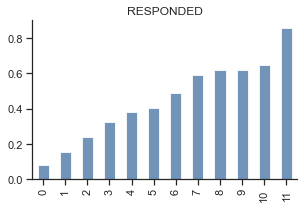

In [33]:
crosstabplots(training1[['RESPONDED']], training1['RESP'],cols=3)
plt.show()

In [34]:
#RESPONDED_6
variable = 'RESPONDED'

counts = data1[variable].value_counts() 
for level in counts.index:
    if level >=6:
        data1.loc[data1[variable]==level, variable] = 6
dummies = pd.get_dummies(data1[variable],  prefix = variable, drop_first=True)

data1 = data1.join(dummies)

data1['RESPONDED']=data1['RESPONDED']
RESPONDED_dummies = list(dummies.columns) 

binary += RESPONDED_dummies
training1 = data1.loc[index_train,:]
validation_test1 = data1.loc[index_valid_test,:]

mi_RESPONDED_dummies = mutual_info_classif(training1[RESPONDED_dummies] ,training1['RESP'], n_neighbors=5, 
                         random_state=1, discrete_features=True)
pd.DataFrame({'Mutual Information':mi_RESPONDED_dummies} , index=[RESPONDED_dummies]).sort_values(by='Mutual Information', ascending=False).round(3)

,Mutual Information
RESPONDED_6,0.017
RESPONDED_4,0.006
RESPONDED_3,0.005
RESPONDED_5,0.005
RESPONDED_2,0.002
RESPONDED_1,0.000


In [35]:
#TOTAL_SPENDING
data1['total_spend']=data1[['AMSPEND','PSSPEND','CCSPEND','AXSPEND']].sum(axis=1)
training1 = data1.loc[index_train,:]
validation_test1 = data1.loc[index_valid_test,:]

mi_total_spend = mutual_info_classif(training1[['total_spend']] ,training1['RESP'], n_neighbors=5, 
                         random_state=1, discrete_features=False)
pd.DataFrame({'Mutual Information':mi_total_spend} , index=[['total_spend']]).sort_values(by='Mutual Information', ascending=False).round(3)

,Mutual Information
total_spend,0.056


### OFFICIAL INPUTS

In [36]:
official_continuous=['LTFREDAY','FREDAYS','MON','SMONSPEND','total_spend','SPENDING_PLEGWEAR',\
                     'SPENDING_PSWEATERS']

official_discrete=['FRE','STYLES','CLASSES']

official_binary=['CC_CARD','RESPONDED_6']

### DATA PREPROCESSING

In [37]:
#Logarithm transformation
training1[official_continuous+official_discrete]=np.log(training1[official_continuous+official_discrete]+1)
validation_test1[official_continuous+official_discrete]=np.log(validation_test1[official_continuous+official_discrete]+1)

In [38]:
#Min max scaling
scaler = MinMaxScaler()
scaler.fit(training1[official_continuous+official_discrete])
training1[official_continuous+official_discrete]=scaler.transform(training1[official_continuous+official_discrete])
validation_test1[official_continuous+official_discrete]=scaler.transform(validation_test1[official_continuous+official_discrete])

In [39]:
X_train = training1[official_continuous+official_discrete+official_binary]
y_train = training1['RESP']
X_valid_test = validation_test1[official_continuous+official_discrete+official_binary]
y_valid_test = validation_test1['RESP']

# LOGISTIC REGRESSION - BASELINE MODEL

In [40]:
#fit the baseline model with the training set
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [41]:
X_train.corr()

,LTFREDAY,FREDAYS,MON,SMONSPEND,total_spend,SPENDING_PLEGWEAR,SPENDING_PSWEATERS,FRE,STYLES,CLASSES,CC_CARD,RESPONDED_6
LTFREDAY,1.000000,0.818493,-0.629759,-0.633855,-0.630372,-0.630206,-0.624728,-0.750553,-0.728432,-0.690727,-0.475818,-0.314675
FREDAYS,0.818493,1.000000,-0.585176,-0.593529,-0.586023,-0.584941,-0.579698,-0.762746,-0.677411,-0.633677,-0.328771,-0.314965
MON,-0.629759,-0.585176,1.000000,0.590114,0.999604,0.999742,0.994938,0.760391,0.892747,0.855761,0.459251,0.390891
SMONSPEND,-0.633855,-0.593529,0.590114,1.000000,0.590126,0.590213,0.580167,0.576233,0.611421,0.595465,0.336383,0.240996
total_spend,-0.630372,-0.586023,0.999604,0.590126,1.000000,0.999343,0.994473,0.761371,0.893450,0.856537,0.459169,0.390999
SPENDING_PLEGWEAR,-0.630206,-0.584941,0.999742,0.590213,0.999343,1.000000,0.994605,0.761016,0.894001,0.856896,0.459537,0.390765
SPENDING_PSWEATERS,-0.624728,-0.579698,0.994938,0.580167,0.994473,0.994605,1.000000,0.760833,0.897150,0.844656,0.455072,0.392123
FRE,-0.750553,-0.762746,0.760391,0.576233,0.761371,0.761016,0.760833,1.000000,0.870430,0.816960,0.427878,0.449663
STYLES,-0.728432,-0.677411,0.892747,0.611421,0.893450,0.894001,0.897150,0.870430,1.000000,0.930931,0.479414,0.411743
CLASSES,-0.690727,-0.633677,0.855761,0.595465,0.856537,0.856896,0.844656,0.816960,0.930931,1.000000,0.463706,0.344829


In [42]:
#The log of the odd estimated by baseline logistic regression
log_odd_lr = lr.predict_proba(X_train)[:,1]/(1-lr.predict_proba(X_train)[:,1])

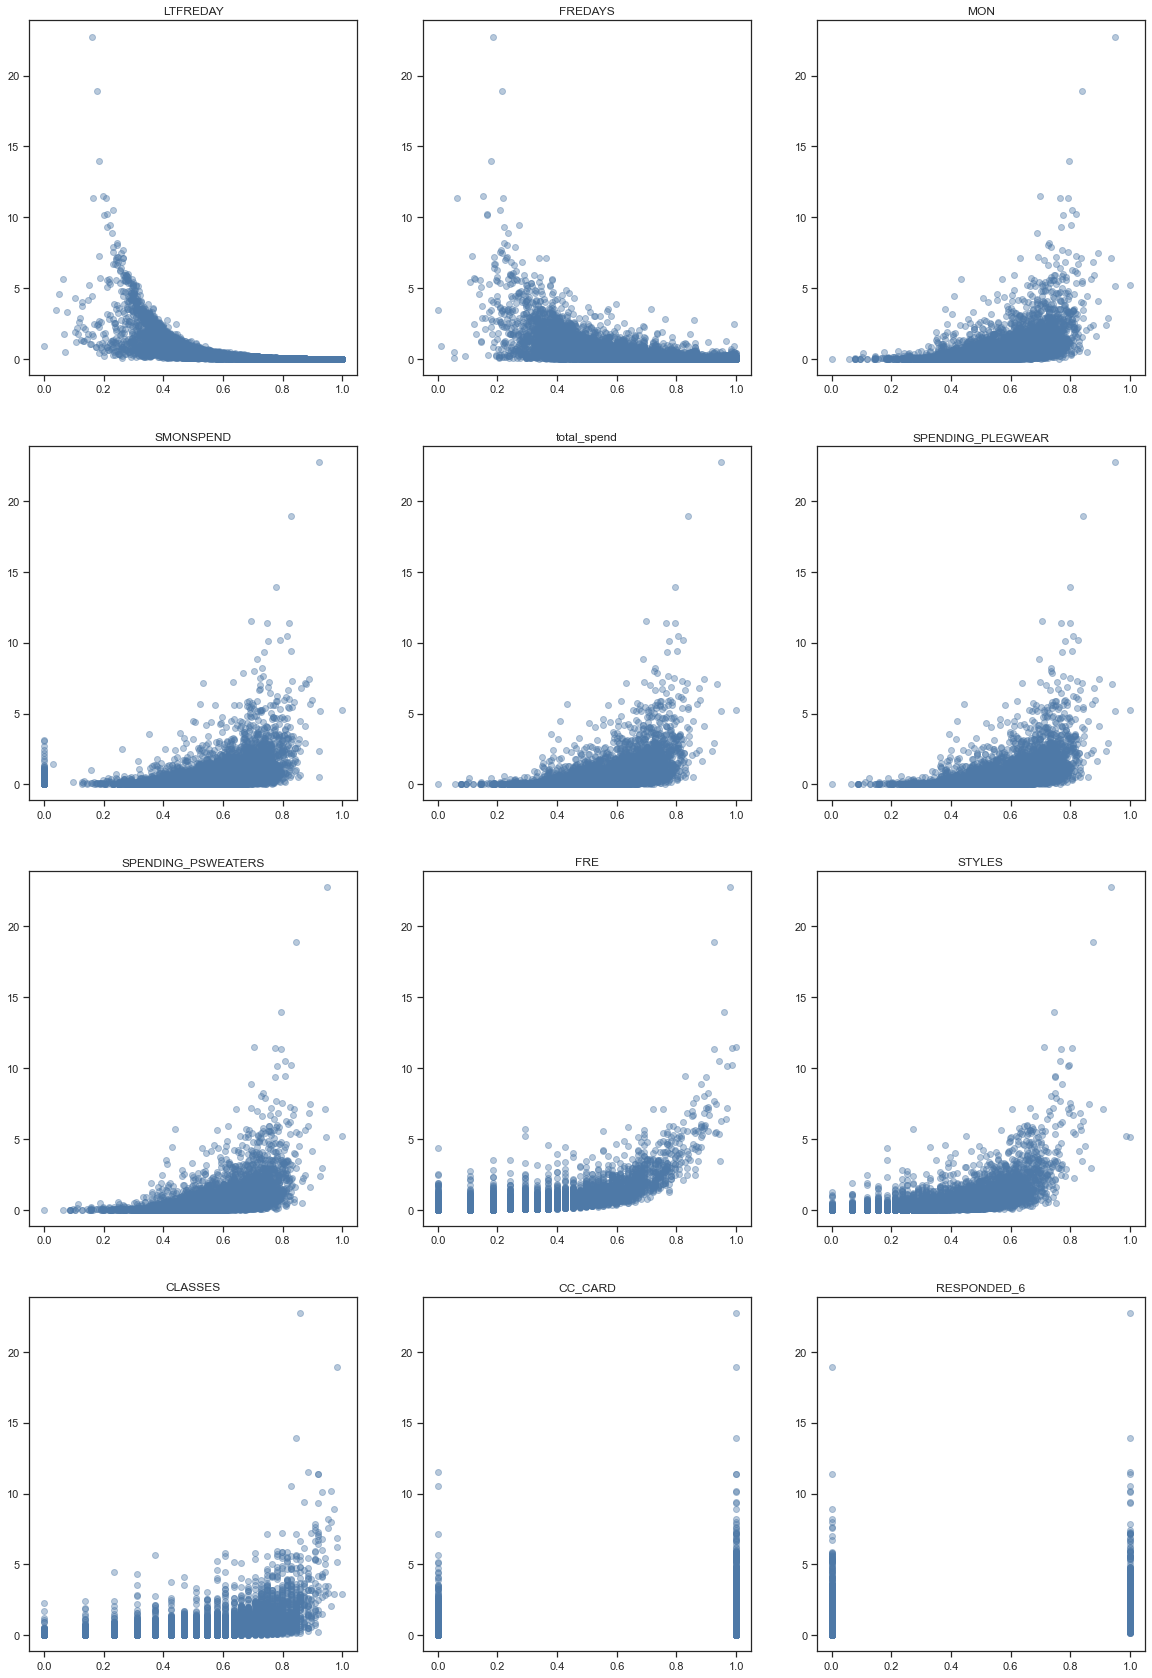

In [43]:
#Scatterplots of the log of the odds against the inputs
fig, axes = plt.subplots(4, 3)
fig.set_figheight(30)
fig.set_figwidth(20)
i=0
j=0
for variable in X_train.columns:
    axes[i,j].scatter(x=X_train[variable].values,y=log_odd_lr,alpha=0.4)
    axes[i,j].set_title('{}'.format(variable))
    j=j+1
    if j==3:
        j=0
        i=i+1
plt.savefig('lr_odd.png')

# $L_2$-PENALIZED LOGISTIC REGRESSION

In [44]:
model = LogisticRegression(class_weight = "balanced",max_iter = 400)

skf = StratifiedKFold(n_splits=7, shuffle = True, random_state=1) #migh consider RepeatedStratifiedKFold

#actual lambda, since C = 1/lam
lams = np.linspace(start = 30, stop = 0.1, num = 40)
print("lambdas:\n" + str(lams) + "\n")
Cs = np.reciprocal(lams) 
print("Cs:\n" + str(Cs))

lambdas:
[30.         29.23333333 28.46666667 27.7        26.93333333 26.16666667
 25.4        24.63333333 23.86666667 23.1        22.33333333 21.56666667
 20.8        20.03333333 19.26666667 18.5        17.73333333 16.96666667
 16.2        15.43333333 14.66666667 13.9        13.13333333 12.36666667
 11.6        10.83333333 10.06666667  9.3         8.53333333  7.76666667
  7.          6.23333333  5.46666667  4.7         3.93333333  3.16666667
  2.4         1.63333333  0.86666667  0.1       ]

Cs:
[ 0.03333333  0.03420753  0.03512881  0.03610108  0.03712871  0.03821656
  0.03937008  0.0405954   0.04189944  0.04329004  0.04477612  0.04636785
  0.04807692  0.04991681  0.05190311  0.05405405  0.05639098  0.0589391
  0.0617284   0.06479482  0.06818182  0.07194245  0.07614213  0.08086253
  0.0862069   0.09230769  0.09933775  0.10752688  0.1171875   0.12875536
  0.14285714  0.16042781  0.18292683  0.21276596  0.25423729  0.31578947
  0.41666667  0.6122449   1.15384615 10.        ]


In [45]:
#Tuning the penalty hyperparameter
space = {'C': Cs, \
         'solver': ['saga'],
         'penalty':['l2']
        }
clf = GridSearchCV(estimator = model, param_grid = space, cv = skf, scoring='f1', n_jobs=-1)
clf.fit(X_train, y_train)
pd.DataFrame(clf.cv_results_).sort_values(by = 'param_penalty')[['param_penalty','param_C','param_solver','mean_test_score','std_test_score']]


,param_penalty,param_C,param_solver,mean_test_score,std_test_score
0,l2,0.033333,saga,0.489096,0.013255
22,l2,0.076142,saga,0.502293,0.012098
23,l2,0.080863,saga,0.502698,0.012259
24,l2,0.086207,saga,0.502887,0.012097
25,l2,0.092308,saga,0.503787,0.012718
26,l2,0.099338,saga,0.505650,0.012881
27,l2,0.107527,saga,0.507307,0.012497
28,l2,0.117187,saga,0.508386,0.013011
21,l2,0.071942,saga,0.501109,0.011263
29,l2,0.128755,saga,0.508990,0.011682


In [46]:
skf = StratifiedKFold(n_splits = 7, random_state = 1, shuffle = True) # shuffle each class's samples before splitting

#get different prediction thresholds
thresholds = np.linspace(start = 0.2, stop = 0.4, num = 100).tolist()
thresholds.append(np.mean(data1['RESP'] == 1)) # add the raw data proportion retained
thresholds.sort()

print(thresholds)

t_scores = {}
for t in thresholds:
    t_scores[t] = []

[0.16609935602575898, 0.2, 0.20202020202020204, 0.20404040404040405, 0.20606060606060608, 0.2080808080808081, 0.21010101010101012, 0.21212121212121213, 0.21414141414141416, 0.21616161616161617, 0.2181818181818182, 0.2202020202020202, 0.22222222222222224, 0.22424242424242424, 0.22626262626262628, 0.2282828282828283, 0.23030303030303031, 0.23232323232323232, 0.23434343434343435, 0.2363636363636364, 0.2383838383838384, 0.2404040404040404, 0.24242424242424243, 0.24444444444444446, 0.24646464646464647, 0.2484848484848485, 0.2505050505050505, 0.25252525252525254, 0.2545454545454546, 0.25656565656565655, 0.2585858585858586, 0.2606060606060606, 0.26262626262626265, 0.2646464646464647, 0.26666666666666666, 0.2686868686868687, 0.27070707070707073, 0.2727272727272727, 0.27474747474747474, 0.2767676767676768, 0.2787878787878788, 0.28080808080808084, 0.2828282828282829, 0.28484848484848485, 0.2868686868686869, 0.2888888888888889, 0.2909090909090909, 0.29292929292929293, 0.29494949494949496, 0.29696

In [47]:
#Cross-validation for tuning the threshold
for train_index, test_index in skf.split(X_train, y_train):
    current_X = X_train.iloc[list(train_index)]
    current_y = y_train.iloc[list(train_index)]
    
    test_X = X_train.iloc[list(test_index)]
    test_y = y_train.iloc[list(test_index)]
    
    current_m = LogisticRegression(max_iter = 500, penalty = 'l2', 
                                   solver = 'saga',C=10).fit(current_X, current_y) # class_weight = "balanced",
    
    probs = current_m.predict_proba(test_X)
    prob_1 = pd.Series([e[1] for e in probs.tolist()])
    
    for t in thresholds:
        threshold_prediction = (prob_1 > t).astype(int)
        t_scores[t].append(f1_score(y_true = test_y, y_pred = threshold_prediction))


0.5406461649782546
0.2585858585858586


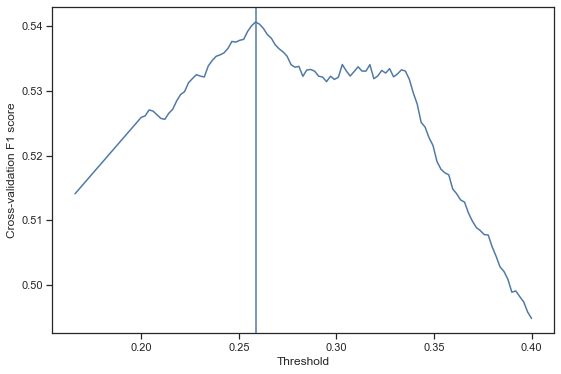

In [48]:
x = list(t_scores.keys())
y = [np.mean(t_scores[t]) for t in t_scores.keys()]

#Best threshold from the above loop
best_x = x[y.index(max(y))]
print(max(y))
print(best_x)

#Plot of cross-validation F1 scores across different thresholds
plt.plot(x,y)
plt.axvline(best_x)
plt.xlabel('Threshold')
plt.ylabel('Cross-validation F1 score')
plt.savefig('cv_plg.png')

In [49]:
#Fit the penalized logistic regression model on training set
plg = LogisticRegression(max_iter = 500, penalty = 'l2',
                                   solver = 'saga',C=10, random_state = 1).fit(X_train, y_train)

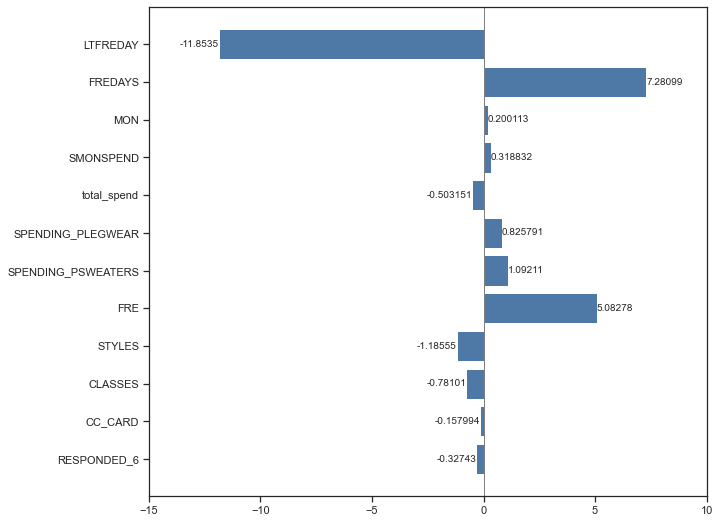

In [99]:
#Plot of coefficient of inputs produced by penalized logistic regression
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(10)

coefplot = ax.barh(y = X_train.columns, width = plg.coef_[0])
    
plt.gca().invert_yaxis()
plt.axvline(x=0., color = "black", linewidth = 0.5)

ax.bar_label(coefplot)
#plt.subplots_adjust(right = 1.6)
ax.set_xlim(-15, 10)

#plt.savefig("plg.png",bbox_inches='tight',dpi = 500)
plt.show()

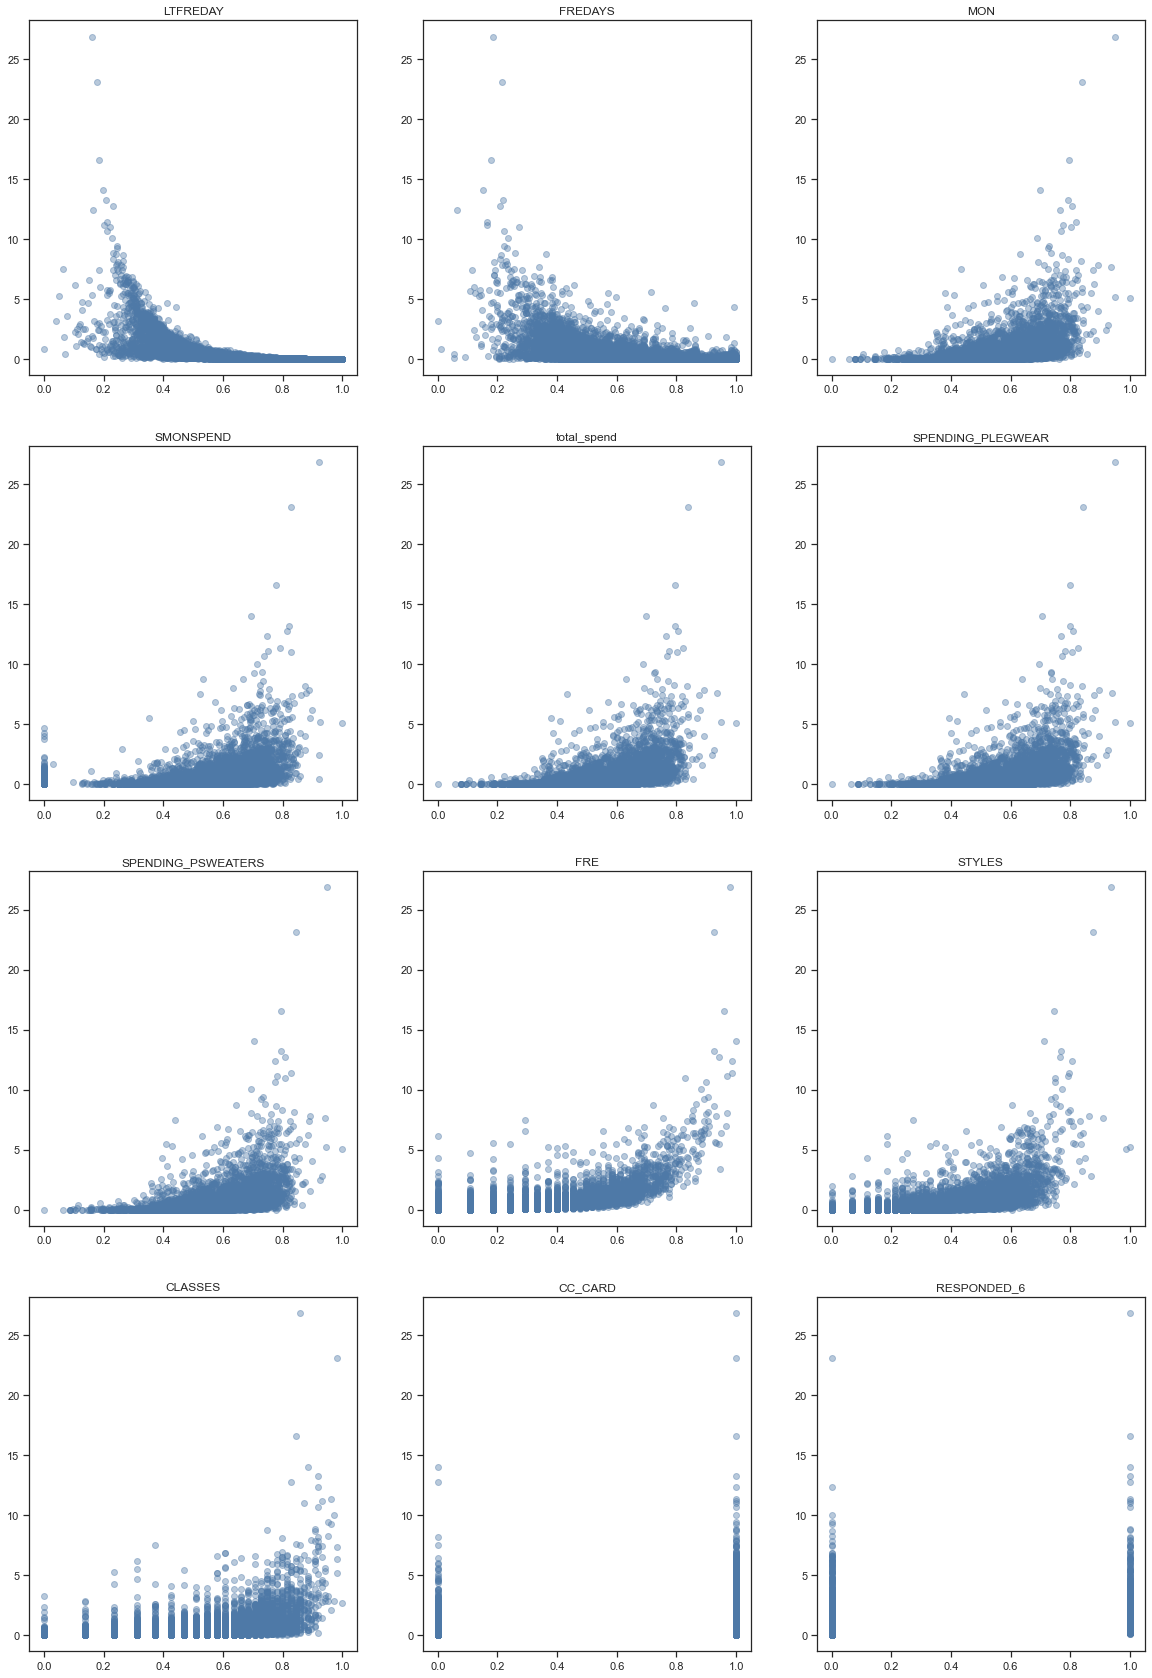

In [51]:
#The log of the odd estimated by penalized logistic regression
log_odd_plg = plg.predict_proba(X_train)[:,1]/(1-plg.predict_proba(X_train)[:,1])

#Scatterplots of the log of the odds against the inputs
fig, axes = plt.subplots(4, 3)
fig.set_figheight(30)
fig.set_figwidth(20)
i=0
j=0
for variable in X_train.columns:
    axes[i,j].scatter(x=X_train[variable].values,y=log_odd_plg,alpha=0.4)
    axes[i,j].set_title('{}'.format(variable))
    j=j+1
    if j==3:
        j=0
        i=i+1
plt.savefig('plg_odd.png')

# LIGHT GRADIENT BOOSTING MACHINE

In [52]:
#Setting Bayes optimisation problem for LightGBM
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 500, 1000)
    num_leaves = trial.suggest_int('num_leaves', 5, 40)
    min_child_samples = trial.suggest_int('min_child_samples', 30, 50)
    reg_alpha = trial.suggest_loguniform('reg_alpha',10**(-4),0.01)
    reg_lambda = trial.suggest_loguniform('reg_lambda',10**(-8),10**(-4))
    subsample = trial.suggest_uniform('subsample', 0.4,1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.8,1)
    positive = trial.suggest_uniform('positive',1,10)
    
    model = lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:positive}, boosting_type = 'gbdt', 
                         n_estimators = n_estimators, learning_rate = 0.05,  
                         num_leaves = num_leaves, min_child_samples=min_child_samples,
                         reg_alpha = reg_alpha, reg_lambda = reg_lambda,
                         subsample = subsample, subsample_freq  = 1, 
                         colsample_bytree = colsample_bytree)
    
    #Optimise using F1 score as justified in the document
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1')
    gain = np.mean(scores)
    
    return gain # returns CV error for the best trial

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, timeout = 12000)  

[I 2022-05-27 18:00:31,997] A new study created in memory with name: no-name-3b648612-a568-4f12-b2a1-1ead752679eb
[I 2022-05-27 18:00:41,530] Trial 0 finished with value: 0.506707930232625 and parameters: {'n_estimators': 687, 'num_leaves': 39, 'min_child_samples': 45, 'reg_alpha': 0.0015751320499779737, 'reg_lambda': 4.207988669606625e-08, 'subsample': 0.49359671220172163, 'colsample_bytree': 0.8116167224336399, 'positive': 8.795585311974417}. Best is trial 0 with value: 0.506707930232625.
[I 2022-05-27 18:00:51,170] Trial 1 finished with value: 0.48658949985811073 and parameters: {'n_estimators': 801, 'num_leaves': 30, 'min_child_samples': 30, 'reg_alpha': 0.008706020878304856, 'reg_lambda': 2.1368329072358724e-05, 'subsample': 0.5274034664069657, 'colsample_bytree': 0.8363649934414201, 'positive': 2.650640588680904}. Best is trial 0 with value: 0.506707930232625.
[I 2022-05-27 18:00:57,605] Trial 2 finished with value: 0.5104761627905543 and parameters: {'n_estimators': 652, 'num_le

[I 2022-05-27 18:02:47,440] Trial 21 finished with value: 0.5095708335879682 and parameters: {'n_estimators': 684, 'num_leaves': 19, 'min_child_samples': 43, 'reg_alpha': 0.0001535719432152692, 'reg_lambda': 5.3386400769005365e-08, 'subsample': 0.8147772108097447, 'colsample_bytree': 0.9034705130428133, 'positive': 3.2679358304643173}. Best is trial 19 with value: 0.5243161522341724.
[I 2022-05-27 18:02:51,453] Trial 22 finished with value: 0.5098695990630903 and parameters: {'n_estimators': 797, 'num_leaves': 5, 'min_child_samples': 47, 'reg_alpha': 0.00010006917825436866, 'reg_lambda': 8.378284248706949e-08, 'subsample': 0.8752074670475325, 'colsample_bytree': 0.9214961404329401, 'positive': 5.001870708435387}. Best is trial 19 with value: 0.5243161522341724.
[I 2022-05-27 18:02:55,786] Trial 23 finished with value: 0.5191301759109681 and parameters: {'n_estimators': 633, 'num_leaves': 13, 'min_child_samples': 40, 'reg_alpha': 0.0002234062321171369, 'reg_lambda': 2.1363197307902103e-

[I 2022-05-27 18:04:22,756] Trial 42 finished with value: 0.5289434171065539 and parameters: {'n_estimators': 727, 'num_leaves': 6, 'min_child_samples': 46, 'reg_alpha': 0.0008798086820759936, 'reg_lambda': 1.002074641321177e-08, 'subsample': 0.9084244099917619, 'colsample_bytree': 0.8347839815358669, 'positive': 2.866666268182439}. Best is trial 36 with value: 0.530444098372452.
[I 2022-05-27 18:04:25,778] Trial 43 finished with value: 0.5321838217692934 and parameters: {'n_estimators': 667, 'num_leaves': 5, 'min_child_samples': 46, 'reg_alpha': 0.005087812521602042, 'reg_lambda': 2.6439254862589906e-08, 'subsample': 0.9084150330629028, 'colsample_bytree': 0.8351689758786517, 'positive': 2.664089177997797}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:04:29,621] Trial 44 finished with value: 0.5076435038962631 and parameters: {'n_estimators': 668, 'num_leaves': 10, 'min_child_samples': 46, 'reg_alpha': 0.004814366316571273, 'reg_lambda': 2.7328701547151203e-08, 's

[I 2022-05-27 18:06:04,995] Trial 63 finished with value: 0.5220083422827066 and parameters: {'n_estimators': 674, 'num_leaves': 10, 'min_child_samples': 46, 'reg_alpha': 0.0007965721101529165, 'reg_lambda': 1.450037069532807e-05, 'subsample': 0.9809781102844572, 'colsample_bytree': 0.8333213172723927, 'positive': 3.643374596043181}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:06:08,559] Trial 64 finished with value: 0.4161707288754166 and parameters: {'n_estimators': 708, 'num_leaves': 7, 'min_child_samples': 48, 'reg_alpha': 0.0015476345849504758, 'reg_lambda': 4.1777947850863854e-05, 'subsample': 0.9292281886672924, 'colsample_bytree': 0.8583238725161442, 'positive': 1.0684421640575983}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:06:12,206] Trial 65 finished with value: 0.5175978580964835 and parameters: {'n_estimators': 691, 'num_leaves': 8, 'min_child_samples': 49, 'reg_alpha': 0.0020701744751426307, 'reg_lambda': 6.8726639732345976e-06

[I 2022-05-27 18:07:21,908] Trial 84 finished with value: 0.5298940183386733 and parameters: {'n_estimators': 718, 'num_leaves': 5, 'min_child_samples': 47, 'reg_alpha': 0.0055291158390908726, 'reg_lambda': 2.826785518782638e-07, 'subsample': 0.827657839739745, 'colsample_bytree': 0.8500640576186903, 'positive': 3.31619403560157}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:07:25,724] Trial 85 finished with value: 0.5183353197625896 and parameters: {'n_estimators': 720, 'num_leaves': 8, 'min_child_samples': 47, 'reg_alpha': 0.00828011805605066, 'reg_lambda': 2.0378943681493644e-08, 'subsample': 0.7624367362071734, 'colsample_bytree': 0.8490688479665087, 'positive': 2.324394249274789}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:07:32,363] Trial 86 finished with value: 0.49674972383710625 and parameters: {'n_estimators': 701, 'num_leaves': 27, 'min_child_samples': 49, 'reg_alpha': 0.0042366799750811245, 'reg_lambda': 2.660818053082381e-05, 'su

[I 2022-05-27 18:08:41,743] Trial 105 finished with value: 0.5200692570846716 and parameters: {'n_estimators': 675, 'num_leaves': 7, 'min_child_samples': 50, 'reg_alpha': 0.005682511584708721, 'reg_lambda': 1.0243228127812386e-07, 'subsample': 0.9085690487431557, 'colsample_bytree': 0.9475375392714338, 'positive': 3.8969268266073644}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:08:44,917] Trial 106 finished with value: 0.5241790502364922 and parameters: {'n_estimators': 687, 'num_leaves': 5, 'min_child_samples': 33, 'reg_alpha': 0.004858546835722551, 'reg_lambda': 1.7266133947347882e-07, 'subsample': 0.9377016547513216, 'colsample_bytree': 0.961547430276207, 'positive': 2.2287519422286017}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:08:48,608] Trial 107 finished with value: 0.5248220008633252 and parameters: {'n_estimators': 703, 'num_leaves': 8, 'min_child_samples': 38, 'reg_alpha': 0.004581390661911962, 'reg_lambda': 2.525197315020505e-07,

[I 2022-05-27 18:10:06,643] Trial 126 finished with value: 0.47682123922972997 and parameters: {'n_estimators': 721, 'num_leaves': 37, 'min_child_samples': 31, 'reg_alpha': 0.0007964409156342455, 'reg_lambda': 3.802286557035647e-06, 'subsample': 0.942317980699097, 'colsample_bytree': 0.8290629160043272, 'positive': 2.1161574168725847}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:10:10,490] Trial 127 finished with value: 0.5240189766534006 and parameters: {'n_estimators': 657, 'num_leaves': 8, 'min_child_samples': 32, 'reg_alpha': 0.0004375768437444764, 'reg_lambda': 7.596879333618022e-08, 'subsample': 0.8937760684026295, 'colsample_bytree': 0.8918157774914764, 'positive': 2.609742722076796}. Best is trial 43 with value: 0.5321838217692934.
[I 2022-05-27 18:10:14,091] Trial 128 finished with value: 0.5284649414209188 and parameters: {'n_estimators': 698, 'num_leaves': 7, 'min_child_samples': 30, 'reg_alpha': 0.0011334583882359613, 'reg_lambda': 2.2772253634689465e-

[I 2022-05-27 18:11:09,392] Trial 147 finished with value: 0.530162249178517 and parameters: {'n_estimators': 531, 'num_leaves': 7, 'min_child_samples': 31, 'reg_alpha': 0.0004763891334534456, 'reg_lambda': 1.2247032990589478e-08, 'subsample': 0.7711709949366329, 'colsample_bytree': 0.813355979207603, 'positive': 3.0786818238151565}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:11:12,578] Trial 148 finished with value: 0.5295737360890904 and parameters: {'n_estimators': 504, 'num_leaves': 9, 'min_child_samples': 33, 'reg_alpha': 0.0004859161844351462, 'reg_lambda': 1.24994698411162e-08, 'subsample': 0.7633573803626003, 'colsample_bytree': 0.8263636307974984, 'positive': 3.2291290422642462}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:11:17,729] Trial 149 finished with value: 0.5094140138188512 and parameters: {'n_estimators': 516, 'num_leaves': 21, 'min_child_samples': 31, 'reg_alpha': 0.0003627839973227107, 'reg_lambda': 2.1085942697194218e

[I 2022-05-27 18:12:08,785] Trial 168 finished with value: 0.4710439334857662 and parameters: {'n_estimators': 512, 'num_leaves': 6, 'min_child_samples': 37, 'reg_alpha': 0.0006208579352651079, 'reg_lambda': 1.017739002489701e-08, 'subsample': 0.6403957339052044, 'colsample_bytree': 0.8370867556531081, 'positive': 9.123273697530266}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:12:11,197] Trial 169 finished with value: 0.5325288153111007 and parameters: {'n_estimators': 529, 'num_leaves': 5, 'min_child_samples': 35, 'reg_alpha': 0.0004311388347203689, 'reg_lambda': 1.2685719363707644e-08, 'subsample': 0.5892583917835368, 'colsample_bytree': 0.8306117523701426, 'positive': 2.7087356300780523}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:12:13,722] Trial 170 finished with value: 0.5333099678208926 and parameters: {'n_estimators': 529, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0007299332701942554, 'reg_lambda': 1.2817483126140927

[I 2022-05-27 18:13:05,851] Trial 189 finished with value: 0.5280930964718029 and parameters: {'n_estimators': 534, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0010094326406250402, 'reg_lambda': 1.2748911021103972e-08, 'subsample': 0.5022077169439388, 'colsample_bytree': 0.8144381294718902, 'positive': 2.790881355954025}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:13:08,933] Trial 190 finished with value: 0.5273697029934187 and parameters: {'n_estimators': 562, 'num_leaves': 7, 'min_child_samples': 34, 'reg_alpha': 0.00035225748007179864, 'reg_lambda': 1.7605934832733107e-08, 'subsample': 0.4849244430407091, 'colsample_bytree': 0.8047856241704697, 'positive': 3.1726888823636314}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:13:11,230] Trial 191 finished with value: 0.5276099964923909 and parameters: {'n_estimators': 508, 'num_leaves': 5, 'min_child_samples': 36, 'reg_alpha': 0.0008439324133822542, 'reg_lambda': 1.03004594311465

[I 2022-05-27 18:14:06,027] Trial 210 finished with value: 0.5305650144168388 and parameters: {'n_estimators': 598, 'num_leaves': 5, 'min_child_samples': 35, 'reg_alpha': 0.0007356481108973067, 'reg_lambda': 1.2011636282001984e-08, 'subsample': 0.4755604035929586, 'colsample_bytree': 0.8367253864177702, 'positive': 3.003694008178165}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:14:08,425] Trial 211 finished with value: 0.5301932518835851 and parameters: {'n_estimators': 524, 'num_leaves': 5, 'min_child_samples': 33, 'reg_alpha': 0.0006843465192972784, 'reg_lambda': 1.379931819743135e-08, 'subsample': 0.5078039901016751, 'colsample_bytree': 0.8310470513580843, 'positive': 2.6529327887915515}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:14:11,079] Trial 212 finished with value: 0.5313959173907608 and parameters: {'n_estimators': 521, 'num_leaves': 5, 'min_child_samples': 34, 'reg_alpha': 0.0008380812474681131, 'reg_lambda': 1.2109925196512254

[I 2022-05-27 18:15:07,479] Trial 231 finished with value: 0.5289653770668622 and parameters: {'n_estimators': 655, 'num_leaves': 5, 'min_child_samples': 36, 'reg_alpha': 0.0007083611949507817, 'reg_lambda': 1.1913047867050643e-08, 'subsample': 0.5561530267644649, 'colsample_bytree': 0.8371107831873426, 'positive': 3.0821240640885375}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:15:10,267] Trial 232 finished with value: 0.5304174811816895 and parameters: {'n_estimators': 585, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0008373379099244088, 'reg_lambda': 1.2656002521603886e-08, 'subsample': 0.5372703238107404, 'colsample_bytree': 0.8264152358394986, 'positive': 2.9211590463191426}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:15:13,123] Trial 233 finished with value: 0.5319340860430233 and parameters: {'n_estimators': 621, 'num_leaves': 5, 'min_child_samples': 34, 'reg_alpha': 0.0006549783607091783, 'reg_lambda': 1.01714958418546

[I 2022-05-27 18:16:13,383] Trial 252 finished with value: 0.5243192390960123 and parameters: {'n_estimators': 644, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0007623455495332388, 'reg_lambda': 1.005543634341922e-08, 'subsample': 0.49096140407828387, 'colsample_bytree': 0.8295834493643177, 'positive': 2.408493953006286}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:16:15,898] Trial 253 finished with value: 0.5310670735624985 and parameters: {'n_estimators': 539, 'num_leaves': 5, 'min_child_samples': 34, 'reg_alpha': 0.0005903772146812853, 'reg_lambda': 1.345923043131339e-08, 'subsample': 0.6780537972591435, 'colsample_bytree': 0.8183934957286952, 'positive': 2.8025873810369184}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:16:19,056] Trial 254 finished with value: 0.5116497245844063 and parameters: {'n_estimators': 628, 'num_leaves': 6, 'min_child_samples': 36, 'reg_alpha': 0.0001210954588308247, 'reg_lambda': 1.0013432494761682

[I 2022-05-27 18:17:14,794] Trial 273 finished with value: 0.5304238040826466 and parameters: {'n_estimators': 646, 'num_leaves': 6, 'min_child_samples': 40, 'reg_alpha': 0.0007831833894687212, 'reg_lambda': 1.8501152352208138e-08, 'subsample': 0.5484816893914268, 'colsample_bytree': 0.8195004787360276, 'positive': 3.055955398977046}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:17:17,542] Trial 274 finished with value: 0.5244510553518215 and parameters: {'n_estimators': 531, 'num_leaves': 5, 'min_child_samples': 36, 'reg_alpha': 0.0009949093621405443, 'reg_lambda': 1.2107994891149523e-08, 'subsample': 0.7117393086320243, 'colsample_bytree': 0.8253263899068112, 'positive': 2.1896661064633864}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:17:20,539] Trial 275 finished with value: 0.49018778687049014 and parameters: {'n_estimators': 561, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0008717256923501838, 'reg_lambda': 1.45735298973901

[I 2022-05-27 18:18:23,936] Trial 294 finished with value: 0.5326366398945936 and parameters: {'n_estimators': 591, 'num_leaves': 6, 'min_child_samples': 34, 'reg_alpha': 0.0012981030563367216, 'reg_lambda': 2.516804131217401e-08, 'subsample': 0.6822667406297594, 'colsample_bytree': 0.829865541458547, 'positive': 2.927214122279426}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:18:26,720] Trial 295 finished with value: 0.5306357069330211 and parameters: {'n_estimators': 585, 'num_leaves': 6, 'min_child_samples': 34, 'reg_alpha': 0.0011284647210548183, 'reg_lambda': 2.730196246967751e-08, 'subsample': 0.6904793125702156, 'colsample_bytree': 0.8311469212606303, 'positive': 2.885258052510487}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:18:32,925] Trial 296 finished with value: 0.4981662612693823 and parameters: {'n_estimators': 596, 'num_leaves': 33, 'min_child_samples': 34, 'reg_alpha': 0.0012096440955427904, 'reg_lambda': 3.2941298456809904e-

[I 2022-05-27 18:19:32,752] Trial 315 finished with value: 0.5316195734499696 and parameters: {'n_estimators': 597, 'num_leaves': 5, 'min_child_samples': 36, 'reg_alpha': 0.0011529630980931485, 'reg_lambda': 2.5794954044873416e-08, 'subsample': 0.7488757707998717, 'colsample_bytree': 0.8328519725191569, 'positive': 3.030302881238805}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:19:35,665] Trial 316 finished with value: 0.5245873299760593 and parameters: {'n_estimators': 574, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0013859369794258893, 'reg_lambda': 3.3346227640676785e-08, 'subsample': 0.4117524193597551, 'colsample_bytree': 0.8441183274174657, 'positive': 3.3385464566589764}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:19:38,422] Trial 317 finished with value: 0.5293852175173607 and parameters: {'n_estimators': 555, 'num_leaves': 7, 'min_child_samples': 33, 'reg_alpha': 0.001528596170052359, 'reg_lambda': 5.045291526590895e

[I 2022-05-27 18:20:31,936] Trial 336 finished with value: 0.528702231950171 and parameters: {'n_estimators': 547, 'num_leaves': 6, 'min_child_samples': 34, 'reg_alpha': 0.001062332974705766, 'reg_lambda': 2.596817803892743e-08, 'subsample': 0.6967716609209773, 'colsample_bytree': 0.8402871558174588, 'positive': 2.7296751158412604}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:20:34,667] Trial 337 finished with value: 0.5296054878862606 and parameters: {'n_estimators': 589, 'num_leaves': 5, 'min_child_samples': 34, 'reg_alpha': 0.0011272729070031498, 'reg_lambda': 1.9702686407001423e-08, 'subsample': 0.6082997825648431, 'colsample_bytree': 0.8335725824735424, 'positive': 3.25504973386812}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:20:37,496] Trial 338 finished with value: 0.5257724796473895 and parameters: {'n_estimators': 562, 'num_leaves': 7, 'min_child_samples': 35, 'reg_alpha': 0.0009488962588800111, 'reg_lambda': 4.693589485607623e-08

[I 2022-05-27 18:21:47,731] Trial 357 finished with value: 0.5041987973220069 and parameters: {'n_estimators': 557, 'num_leaves': 7, 'min_child_samples': 33, 'reg_alpha': 0.0003749897834424611, 'reg_lambda': 1.8429990966491477e-08, 'subsample': 0.5787536134718295, 'colsample_bytree': 0.8226541483804847, 'positive': 5.502788837759557}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:21:50,405] Trial 358 finished with value: 0.5263621757960542 and parameters: {'n_estimators': 569, 'num_leaves': 6, 'min_child_samples': 31, 'reg_alpha': 0.0010647552749438525, 'reg_lambda': 2.4431708262138734e-08, 'subsample': 0.7009308489832797, 'colsample_bytree': 0.8408985789565234, 'positive': 3.0461528286469095}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:21:53,536] Trial 359 finished with value: 0.5271709372418754 and parameters: {'n_estimators': 541, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0015446711161670851, 'reg_lambda': 5.182533332103908

[I 2022-05-27 18:22:49,621] Trial 378 finished with value: 0.4748838512025239 and parameters: {'n_estimators': 556, 'num_leaves': 5, 'min_child_samples': 32, 'reg_alpha': 0.0015558713260618892, 'reg_lambda': 1.67137531420533e-08, 'subsample': 0.6269303656103514, 'colsample_bytree': 0.8355704636624751, 'positive': 8.575620665013151}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:22:52,470] Trial 379 finished with value: 0.5272371335654652 and parameters: {'n_estimators': 582, 'num_leaves': 7, 'min_child_samples': 34, 'reg_alpha': 0.0019085314621971822, 'reg_lambda': 1.484899695425542e-08, 'subsample': 0.5954325302458696, 'colsample_bytree': 0.8389482018220538, 'positive': 2.727269622187332}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:22:55,199] Trial 380 finished with value: 0.5304482037791314 and parameters: {'n_estimators': 571, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0014409698458344785, 'reg_lambda': 1.0020706186740614e-0

[I 2022-05-27 18:24:02,197] Trial 399 finished with value: 0.5319437678748198 and parameters: {'n_estimators': 619, 'num_leaves': 6, 'min_child_samples': 34, 'reg_alpha': 0.0014044754518286948, 'reg_lambda': 2.31085666512399e-08, 'subsample': 0.4970024198978697, 'colsample_bytree': 0.8359924777598133, 'positive': 3.080399255199901}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:24:06,333] Trial 400 finished with value: 0.5208219093162455 and parameters: {'n_estimators': 594, 'num_leaves': 9, 'min_child_samples': 35, 'reg_alpha': 0.0012107310687192088, 'reg_lambda': 1.405060948558915e-08, 'subsample': 0.6416953206344139, 'colsample_bytree': 0.8740938347343147, 'positive': 2.3150938610859972}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:24:09,352] Trial 401 finished with value: 0.5238973659255018 and parameters: {'n_estimators': 535, 'num_leaves': 8, 'min_child_samples': 32, 'reg_alpha': 0.0009279443670957698, 'reg_lambda': 1.1630688808928702e-

[I 2022-05-27 18:25:13,772] Trial 420 finished with value: 0.5288632321324085 and parameters: {'n_estimators': 534, 'num_leaves': 6, 'min_child_samples': 35, 'reg_alpha': 0.0009689669079449143, 'reg_lambda': 1.989570272502031e-08, 'subsample': 0.5042437033565947, 'colsample_bytree': 0.8137078937397109, 'positive': 2.9047585973373726}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:25:18,810] Trial 421 finished with value: 0.5291253837510744 and parameters: {'n_estimators': 919, 'num_leaves': 5, 'min_child_samples': 34, 'reg_alpha': 0.0013190434846521916, 'reg_lambda': 1.2198543333848092e-08, 'subsample': 0.6561156791218068, 'colsample_bytree': 0.8302453480337629, 'positive': 3.0310697800430297}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:25:22,238] Trial 422 finished with value: 0.5329240104541723 and parameters: {'n_estimators': 561, 'num_leaves': 6, 'min_child_samples': 33, 'reg_alpha': 0.001148157839189483, 'reg_lambda': 1.3645316124479964

[I 2022-05-27 18:26:58,229] Trial 441 finished with value: 0.5273162117261503 and parameters: {'n_estimators': 581, 'num_leaves': 7, 'min_child_samples': 30, 'reg_alpha': 0.0009108911963302011, 'reg_lambda': 1.6534455396346592e-08, 'subsample': 0.49693492065239353, 'colsample_bytree': 0.817310918660032, 'positive': 2.9012071920960727}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:27:02,309] Trial 442 finished with value: 0.5319207308252436 and parameters: {'n_estimators': 559, 'num_leaves': 5, 'min_child_samples': 34, 'reg_alpha': 0.0014435553656045466, 'reg_lambda': 1.9032444384422023e-08, 'subsample': 0.6063055935567767, 'colsample_bytree': 0.8224021781010169, 'positive': 3.332604142647829}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:27:06,346] Trial 443 finished with value: 0.5312938906513652 and parameters: {'n_estimators': 616, 'num_leaves': 6, 'min_child_samples': 34, 'reg_alpha': 0.0010996397546436242, 'reg_lambda': 1.167284920325898

[I 2022-05-27 18:28:17,594] Trial 462 finished with value: 0.5234275174666561 and parameters: {'n_estimators': 575, 'num_leaves': 7, 'min_child_samples': 41, 'reg_alpha': 0.0014130184312985275, 'reg_lambda': 7.447604588433944e-08, 'subsample': 0.6441558418309001, 'colsample_bytree': 0.8400619890351273, 'positive': 2.4381360020855007}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:28:20,678] Trial 463 finished with value: 0.5297659361761481 and parameters: {'n_estimators': 592, 'num_leaves': 6, 'min_child_samples': 30, 'reg_alpha': 0.0011220624009180516, 'reg_lambda': 5.481176095242952e-08, 'subsample': 0.652086244083329, 'colsample_bytree': 0.9819033397687162, 'positive': 2.9831759052926152}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:28:23,381] Trial 464 finished with value: 0.5305955454349592 and parameters: {'n_estimators': 558, 'num_leaves': 6, 'min_child_samples': 30, 'reg_alpha': 0.0012453846621454415, 'reg_lambda': 3.21790229631838e-0

[I 2022-05-27 18:29:40,345] Trial 483 finished with value: 0.5302085635491715 and parameters: {'n_estimators': 548, 'num_leaves': 6, 'min_child_samples': 40, 'reg_alpha': 0.0009025345191386126, 'reg_lambda': 1.5814246508489308e-08, 'subsample': 0.6102239407273431, 'colsample_bytree': 0.834195766209351, 'positive': 3.210622134953509}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:29:43,795] Trial 484 finished with value: 0.5311021003826487 and parameters: {'n_estimators': 598, 'num_leaves': 5, 'min_child_samples': 30, 'reg_alpha': 0.0015246789647680402, 'reg_lambda': 4.368167346693513e-08, 'subsample': 0.5957701895965941, 'colsample_bytree': 0.8383452412431064, 'positive': 2.8010985306761023}. Best is trial 132 with value: 0.5349515093265987.
[I 2022-05-27 18:29:50,351] Trial 485 finished with value: 0.5234679012795673 and parameters: {'n_estimators': 624, 'num_leaves': 6, 'min_child_samples': 41, 'reg_alpha': 0.0010797722633963558, 'reg_lambda': 2.112304269426736e-

In [53]:
study.best_params

{'n_estimators': 550,
 'num_leaves': 6,
 'min_child_samples': 30,
 'reg_alpha': 0.0006765237781964686,
 'reg_lambda': 1.1211018630926522e-08,
 'subsample': 0.900156348597056,
 'colsample_bytree': 0.8207767188052122,
 'positive': 2.5775420426497027}

In [54]:
#Fit LightGBM on training set with tuned values of hyperparameters
lgbm=lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:2.5775420426497027}, boosting_type = 'gbdt', 
                         n_estimators = 550, learning_rate = 0.02,  
                         num_leaves = 6, min_child_samples=30,
                         reg_alpha = 0.0006765237781964686, reg_lambda =  1.1211018630926522e-08,
                         subsample =0.900156348597056, subsample_freq  = 1, 
                         colsample_bytree= 0.8207767188052122)
lgbm.fit(X_train,y_train)


LGBMClassifier(class_weight={0: 1, 1: 2.5775420426497027},
               colsample_bytree=0.8207767188052122, learning_rate=0.02,
               min_child_samples=30, n_estimators=550, num_leaves=6,
               objective='binary', reg_alpha=0.0006765237781964686,
               reg_lambda=1.1211018630926522e-08, subsample=0.900156348597056,
               subsample_freq=1)

In [55]:
def plot_feature_importance(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

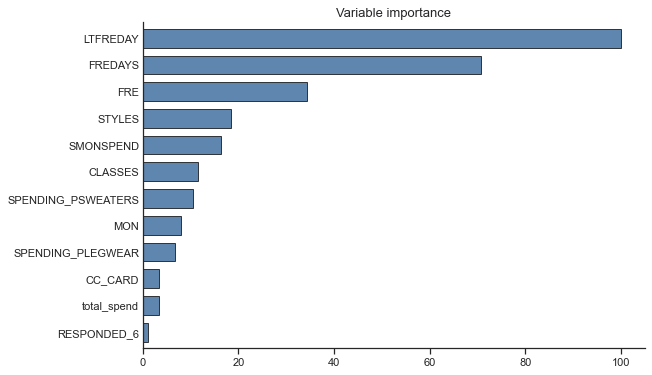

<Figure size 648x432 with 0 Axes>

In [56]:
#Feature importance
plot_feature_importance(lgbm, X_train.columns)
plt.show()
plt.savefig('lgbm_fi')

# RANDOM FOREST

In [57]:
from sklearn.ensemble import RandomForestClassifier
#Setting Bayes optimisation problem for random forest

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 50)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes',10,20)
    positive = trial.suggest_uniform('positive',2,5)
    
    
    #Fix the number of trees to 200 to save computational cost
    model = RandomForestClassifier(n_estimators = 200,  
                                  criterion = criterion,  
                            
                                  min_samples_leaf= min_samples_leaf, max_leaf_nodes=max_leaf_nodes,
                                  random_state = 1,class_weight={0:1,1:positive})
    

    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1')
    gain = np.mean(scores)
    
    return gain # returns CV error for the best trial

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=300, timeout = 12000)  


[I 2022-05-27 18:30:36,608] A new study created in memory with name: no-name-c55f2f64-c636-4f13-a329-36d139542409
[I 2022-05-27 18:30:48,782] Trial 0 finished with value: 0.49697692837690155 and parameters: {'criterion': 'gini', 'min_samples_leaf': 45, 'max_leaf_nodes': 16, 'positive': 2.4680559213273097}. Best is trial 0 with value: 0.49697692837690155.
[I 2022-05-27 18:31:04,526] Trial 1 finished with value: 0.5024425548909685 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 48, 'max_leaf_nodes': 16, 'positive': 4.124217733388137}. Best is trial 1 with value: 0.5024425548909685.
[I 2022-05-27 18:31:15,857] Trial 2 finished with value: 0.49716250883554125 and parameters: {'criterion': 'gini', 'min_samples_leaf': 47, 'max_leaf_nodes': 12, 'positive': 2.5454749016213016}. Best is trial 1 with value: 0.5024425548909685.
[I 2022-05-27 18:31:30,001] Trial 3 finished with value: 0.5061477290003122 and parameters: {'criterion': 'gini', 'min_samples_leaf': 41, 'max_leaf_nodes': 14

[I 2022-05-27 18:37:44,821] Trial 32 finished with value: 0.5084061508072624 and parameters: {'criterion': 'gini', 'min_samples_leaf': 35, 'max_leaf_nodes': 19, 'positive': 3.1598873971669628}. Best is trial 25 with value: 0.5096887551557364.
[I 2022-05-27 18:38:00,049] Trial 33 finished with value: 0.5057139601958316 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 17, 'positive': 2.722977525986374}. Best is trial 25 with value: 0.5096887551557364.
[I 2022-05-27 18:38:14,695] Trial 34 finished with value: 0.5029256403225801 and parameters: {'criterion': 'gini', 'min_samples_leaf': 36, 'max_leaf_nodes': 20, 'positive': 2.542898786259857}. Best is trial 25 with value: 0.5096887551557364.
[I 2022-05-27 18:38:33,735] Trial 35 finished with value: 0.501292267346756 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 32, 'max_leaf_nodes': 19, 'positive': 3.572137811775317}. Best is trial 25 with value: 0.5096887551557364.
[I 2022-05-27 18:38:49,234] T

[I 2022-05-27 18:45:35,840] Trial 65 finished with value: 0.5041033564710603 and parameters: {'criterion': 'gini', 'min_samples_leaf': 47, 'max_leaf_nodes': 15, 'positive': 2.7705937614841556}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:45:47,569] Trial 66 finished with value: 0.5064501318585356 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 19, 'positive': 2.625017614382572}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:46:01,451] Trial 67 finished with value: 0.5053495446086333 and parameters: {'criterion': 'gini', 'min_samples_leaf': 36, 'max_leaf_nodes': 13, 'positive': 3.0024441303290814}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:46:16,801] Trial 68 finished with value: 0.5000946822641177 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 4.852514284862618}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:46:28,924] Trial 69 finis

[I 2022-05-27 18:52:58,010] Trial 98 finished with value: 0.5098980774516126 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 2.978978413829005}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:53:11,284] Trial 99 finished with value: 0.5065337293487462 and parameters: {'criterion': 'gini', 'min_samples_leaf': 33, 'max_leaf_nodes': 20, 'positive': 3.3105253388827127}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:53:29,536] Trial 100 finished with value: 0.5042913158286317 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 31, 'max_leaf_nodes': 16, 'positive': 2.8271104596203993}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:53:43,800] Trial 101 finished with value: 0.5108411815502358 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 19, 'positive': 2.8596975980704764}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 18:53:58,521] Trial 10

[I 2022-05-27 19:00:26,901] Trial 131 finished with value: 0.5114752211066154 and parameters: {'criterion': 'gini', 'min_samples_leaf': 33, 'max_leaf_nodes': 20, 'positive': 2.860438021202736}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:00:39,131] Trial 132 finished with value: 0.5113197198302115 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 20, 'positive': 2.8600196657952455}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:00:51,142] Trial 133 finished with value: 0.5110083396117189 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 20, 'positive': 2.8611017486471124}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:01:03,128] Trial 134 finished with value: 0.5106622737700588 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 20, 'positive': 2.902282720982824}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:01:16,258] Trial 135 

[I 2022-05-27 19:07:39,637] Trial 164 finished with value: 0.5106014237193337 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 20, 'positive': 2.8960344202210617}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:07:53,230] Trial 165 finished with value: 0.5061021304386071 and parameters: {'criterion': 'gini', 'min_samples_leaf': 33, 'max_leaf_nodes': 20, 'positive': 2.641094078330776}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:08:07,450] Trial 166 finished with value: 0.5096856592509765 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_leaf_nodes': 20, 'positive': 2.768876180797586}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:08:21,193] Trial 167 finished with value: 0.5111314135203199 and parameters: {'criterion': 'gini', 'min_samples_leaf': 33, 'max_leaf_nodes': 20, 'positive': 2.8412511277847385}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:08:34,687] Trial 168 

[I 2022-05-27 19:15:00,644] Trial 197 finished with value: 0.5087478714224776 and parameters: {'criterion': 'gini', 'min_samples_leaf': 35, 'max_leaf_nodes': 20, 'positive': 3.0013224390326823}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:15:13,791] Trial 198 finished with value: 0.5077699499028174 and parameters: {'criterion': 'gini', 'min_samples_leaf': 33, 'max_leaf_nodes': 20, 'positive': 2.6795899350963075}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:15:26,119] Trial 199 finished with value: 0.509340307352838 and parameters: {'criterion': 'gini', 'min_samples_leaf': 31, 'max_leaf_nodes': 19, 'positive': 2.903502038691867}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:15:37,883] Trial 200 finished with value: 0.5117701800144187 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 2.9556642613801145}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:15:49,963] Trial 201 

[I 2022-05-27 19:21:58,474] Trial 230 finished with value: 0.5104994417521566 and parameters: {'criterion': 'gini', 'min_samples_leaf': 31, 'max_leaf_nodes': 19, 'positive': 2.9518623599657805}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:22:10,967] Trial 231 finished with value: 0.5102147406198728 and parameters: {'criterion': 'gini', 'min_samples_leaf': 30, 'max_leaf_nodes': 20, 'positive': 2.871866096330701}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:22:23,899] Trial 232 finished with value: 0.5113083780843151 and parameters: {'criterion': 'gini', 'min_samples_leaf': 31, 'max_leaf_nodes': 20, 'positive': 2.8279194786751964}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:22:36,794] Trial 233 finished with value: 0.5114485283065324 and parameters: {'criterion': 'gini', 'min_samples_leaf': 31, 'max_leaf_nodes': 20, 'positive': 2.835724548232154}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:22:49,321] Trial 234 

[I 2022-05-27 19:28:56,365] Trial 263 finished with value: 0.5039460272091367 and parameters: {'criterion': 'gini', 'min_samples_leaf': 31, 'max_leaf_nodes': 19, 'positive': 4.181176822552151}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:29:08,198] Trial 264 finished with value: 0.5066017133604688 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 2.647387530969728}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:29:20,259] Trial 265 finished with value: 0.5102354672855107 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 2.8743363550320753}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:29:33,215] Trial 266 finished with value: 0.5098198793231703 and parameters: {'criterion': 'gini', 'min_samples_leaf': 31, 'max_leaf_nodes': 20, 'positive': 2.74906140834134}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:29:45,446] Trial 267 fi

[I 2022-05-27 19:36:01,918] Trial 296 finished with value: 0.5099888642955321 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 2.7458360468262395}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:36:13,944] Trial 297 finished with value: 0.5070378777424238 and parameters: {'criterion': 'gini', 'min_samples_leaf': 30, 'max_leaf_nodes': 20, 'positive': 2.684583068816902}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:36:26,669] Trial 298 finished with value: 0.5111472604495942 and parameters: {'criterion': 'gini', 'min_samples_leaf': 32, 'max_leaf_nodes': 20, 'positive': 2.825066546368444}. Best is trial 43 with value: 0.5123706206819.
[I 2022-05-27 19:36:39,014] Trial 299 finished with value: 0.5046631579352705 and parameters: {'criterion': 'gini', 'min_samples_leaf': 38, 'max_leaf_nodes': 20, 'positive': 2.6178567957716554}. Best is trial 43 with value: 0.5123706206819.


In [58]:
study.best_params

{'criterion': 'gini',
 'min_samples_leaf': 33,
 'max_leaf_nodes': 20,
 'positive': 2.829275106288106}

In [59]:
#Fit the random forest on the training data set with 2000
rf = RandomForestClassifier(n_estimators = 2000,  
                                  criterion = 'gini', 
                                  min_samples_leaf= 33, max_leaf_nodes=20,
                                  random_state = 1,class_weight={0:1,1:2.829275106288106})
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 2.829275106288106},
                       max_leaf_nodes=20, min_samples_leaf=33,
                       n_estimators=2000, random_state=1)

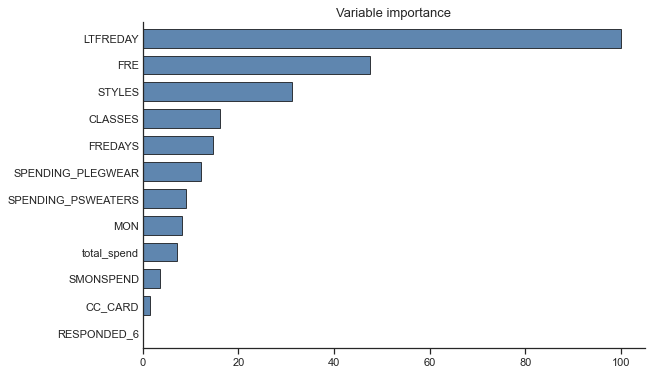

In [60]:
plot_feature_importance(rf, X_train.columns)
plt.show()

# MODEL STACKING

In [61]:
estimators = [('lgbm',lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:2.5775420426497027}, boosting_type = 'gbdt', 
                         n_estimators = 550, learning_rate = 0.02,  
                         num_leaves = 6, min_child_samples=30,
                         reg_alpha = 0.0006765237781964686, reg_lambda =  1.1211018630926522e-08,
                         subsample =0.900156348597056, subsample_freq  = 1, 
                         colsample_bytree= 0.8207767188052122)),\
             ('rf',RandomForestClassifier(n_estimators = 2000,  
                                  criterion = 'gini', 
                                  min_samples_leaf= 33, max_leaf_nodes=20,
                                  random_state = 1,class_weight={0:1,1:2.829275106288106}))]
             
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter = 500, penalty = 'l2',
                                   solver = 'saga',C=10, random_state = 1))

stack.fit(X_train, y_train)

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(class_weight={0: 1,
                                                             1: 2.5775420426497027},
                                               colsample_bytree=0.8207767188052122,
                                               learning_rate=0.02,
                                               min_child_samples=30,
                                               n_estimators=550, num_leaves=6,
                                               objective='binary',
                                               reg_alpha=0.0006765237781964686,
                                               reg_lambda=1.1211018630926522e-08,
                                               subsample=0.900156348597056,
                                               subsample_freq=1)),
                               ('rf',
                                RandomForestClassifier(class_weight={0: 1,
                        

# DEEP FEEDFORWARD NEURAL NETWORK

In [62]:
predictors = X_train.columns
index_train1, index_val1  = train_test_split(np.array(training1.index), stratify=training1[['RESP']], train_size=0.8, random_state=1)

X_train1 = training1.loc[index_train1, predictors].to_numpy()
y_train1 = training1.loc[index_train1, 'RESP'].to_numpy()

X_valid1 = training1.loc[index_val1, predictors].to_numpy()
y_valid1 = training1.loc[index_val1, 'RESP'].to_numpy()

In [63]:
import torch
torch.manual_seed(0)

from torch.utils.data import Dataset

class FraudDataset(Dataset):
    
    def __init__(self, features, response):
        self.features =  torch.from_numpy(features).float()
        self.response = torch.from_numpy(response).float()

    def __len__(self):
        return len(self.response)

    def __getitem__(self, idx):
        return self.features[idx, :], self.response[idx]
    
train_data = FraudDataset(X_train1, y_train1)

In [64]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size = 1024, shuffle=True)

X, y = next(iter(train_loader))

X

tensor([[0.4260, 0.4411, 0.7420,  ..., 0.7820, 1.0000, 1.0000],
        [0.6175, 0.6911, 0.4048,  ..., 0.3112, 1.0000, 0.0000],
        [0.9741, 0.8460, 0.3798,  ..., 0.1377, 0.0000, 0.0000],
        ...,
        [0.4281, 0.3596, 0.6843,  ..., 0.7986, 1.0000, 0.0000],
        [0.7667, 0.7470, 0.5097,  ..., 0.3731, 0.0000, 0.0000],
        [0.3697, 0.5142, 0.6281,  ..., 0.6085, 1.0000, 0.0000]])

In [65]:
from torch import nn
   
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(X_train.shape[1], 128),            
            nn.ELU(alpha=1.0, inplace=False),                       
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),  
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),  
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),  
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),  
            nn.Linear(128, 128),
            nn.ELU(alpha=1.0, inplace=False),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )                        


    def forward(self, features):        
        return self.feedforward(features).flatten() # returns a flat array as desired

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dfn = NeuralNetwork().to(device)

print(dfn)

NeuralNetwork(
  (feedforward): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ELU(alpha=1.0)
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): ELU(alpha=1.0)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): ELU(alpha=1.0)
    (18): Linear(in_features=128, out_features=1, bias=True)
    (19): Sigmoid()
  )
)


In [67]:
def train_loop(dataloader, model, loss_fn, optimiser):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    n_batches = len(dataloader)
    n_obs = len(dataloader.dataset)
    
    for batch, (features, response) in enumerate(dataloader):
        
        # Move data to GPU, if available
        features = features.to(device)
        response  = response.to(device)
        
        # Compute the predictions (forward pass)
        prediction = model(features)
        
        # Evaluate cost function
        loss = loss_fn(prediction, torch.reshape(response, (-1,)))

        # Compute gradient (backward pass)
        optimiser.zero_grad()
        loss.backward()
        
        # Update parameters
        optimiser.step()

        # Print progress
        if batch % int(np.floor(0.2*n_batches)) == 0:
            loss, current = loss.item(), batch * len(response)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{n_obs:>5d}]")

In [68]:
from sklearn.metrics import recall_score, log_loss, average_precision_score

def validation(model):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Predicted probabilities 
    # the .cpu().detach().numpy() part transfers the result the cpu and converts it to a numpy array
    with torch.no_grad():
        y_prob = model(torch.from_numpy(X_valid1).float().to(device)).cpu().detach().numpy()
    
    
    # Classification using the decision threshold
    tau = best_x
    y_pred = (y_prob > tau).astype(int)
    
    # Metrics
    nll = log_loss(y_valid1, y_prob)
    sensitivity = recall_score(y_valid1, y_pred)
    auprc = average_precision_score(y_valid1, y_prob)
      

    print('')
    print('Validation metrics \n')
    print(f"Loss: {np.round(nll, 4)}")
    print(f"Sensitivity: {np.round(sensitivity, 3)}")
    print(f"Average precision: {np.round( auprc, 3)} \n")

In [69]:
epochs = 100
learning_rate = 1e-3

loss_fn = nn.BCELoss() # binary cross-entropy loss
optimiser = torch.optim.Adam(dfn.parameters(), lr = learning_rate) # Adam tends to work well as a default
 
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(train_loader, dfn, loss_fn, optimiser)
    validation(dfn)

print("Done!")

Epoch 1
-------------------------------
Loss: 0.694195  [    0/13913]
Loss: 0.628956  [ 2048/13913]
Loss: 0.542780  [ 4096/13913]
Loss: 0.457875  [ 6144/13913]
Loss: 0.510023  [ 8192/13913]
Loss: 0.472530  [10240/13913]
Loss: 0.427278  [12288/13913]

Validation metrics 

Loss: 0.4505
Sensitivity: 0.071
Average precision: 0.461 

Epoch 2
-------------------------------
Loss: 0.465842  [    0/13913]
Loss: 0.461865  [ 2048/13913]
Loss: 0.431055  [ 4096/13913]
Loss: 0.400542  [ 6144/13913]
Loss: 0.359912  [ 8192/13913]
Loss: 0.366769  [10240/13913]
Loss: 0.385659  [12288/13913]

Validation metrics 

Loss: 0.3844
Sensitivity: 0.481
Average precision: 0.46 

Epoch 3
-------------------------------
Loss: 0.350824  [    0/13913]
Loss: 0.362336  [ 2048/13913]
Loss: 0.371286  [ 4096/13913]
Loss: 0.392527  [ 6144/13913]
Loss: 0.408104  [ 8192/13913]
Loss: 0.335319  [10240/13913]
Loss: 0.340483  [12288/13913]

Validation metrics 

Loss: 0.3648
Sensitivity: 0.495
Average precision: 0.479 

Epoch 4


Loss: 0.302917  [ 4096/13913]
Loss: 0.348709  [ 6144/13913]
Loss: 0.350226  [ 8192/13913]
Loss: 0.326724  [10240/13913]
Loss: 0.304323  [12288/13913]

Validation metrics 

Loss: 0.3346
Sensitivity: 0.621
Average precision: 0.515 

Epoch 27
-------------------------------
Loss: 0.334194  [    0/13913]
Loss: 0.329426  [ 2048/13913]
Loss: 0.320163  [ 4096/13913]
Loss: 0.318516  [ 6144/13913]
Loss: 0.325818  [ 8192/13913]
Loss: 0.330617  [10240/13913]
Loss: 0.334226  [12288/13913]

Validation metrics 

Loss: 0.3369
Sensitivity: 0.699
Average precision: 0.511 

Epoch 28
-------------------------------
Loss: 0.280155  [    0/13913]
Loss: 0.346773  [ 2048/13913]
Loss: 0.309971  [ 4096/13913]
Loss: 0.326795  [ 6144/13913]
Loss: 0.307896  [ 8192/13913]
Loss: 0.349978  [10240/13913]
Loss: 0.323292  [12288/13913]

Validation metrics 

Loss: 0.3324
Sensitivity: 0.673
Average precision: 0.515 

Epoch 29
-------------------------------
Loss: 0.318746  [    0/13913]
Loss: 0.299647  [ 2048/13913]
Loss

Loss: 0.327045  [ 8192/13913]
Loss: 0.347387  [10240/13913]
Loss: 0.285692  [12288/13913]

Validation metrics 

Loss: 0.3351
Sensitivity: 0.574
Average precision: 0.512 

Epoch 52
-------------------------------
Loss: 0.327832  [    0/13913]
Loss: 0.354790  [ 2048/13913]
Loss: 0.311842  [ 4096/13913]
Loss: 0.339539  [ 6144/13913]
Loss: 0.299718  [ 8192/13913]
Loss: 0.309302  [10240/13913]
Loss: 0.314311  [12288/13913]

Validation metrics 

Loss: 0.3398
Sensitivity: 0.735
Average precision: 0.511 

Epoch 53
-------------------------------
Loss: 0.320187  [    0/13913]
Loss: 0.324861  [ 2048/13913]
Loss: 0.326697  [ 4096/13913]
Loss: 0.319786  [ 6144/13913]
Loss: 0.329470  [ 8192/13913]
Loss: 0.317244  [10240/13913]
Loss: 0.306637  [12288/13913]

Validation metrics 

Loss: 0.3322
Sensitivity: 0.694
Average precision: 0.511 

Epoch 54
-------------------------------
Loss: 0.332102  [    0/13913]
Loss: 0.335300  [ 2048/13913]
Loss: 0.334349  [ 4096/13913]
Loss: 0.297198  [ 6144/13913]
Loss

Loss: 0.312532  [ 2048/13913]
Loss: 0.335310  [ 4096/13913]
Loss: 0.334389  [ 6144/13913]
Loss: 0.321638  [ 8192/13913]
Loss: 0.328314  [10240/13913]
Loss: 0.327428  [12288/13913]

Validation metrics 

Loss: 0.3322
Sensitivity: 0.606
Average precision: 0.513 

Epoch 77
-------------------------------
Loss: 0.326349  [    0/13913]
Loss: 0.302896  [ 2048/13913]
Loss: 0.300517  [ 4096/13913]
Loss: 0.313017  [ 6144/13913]
Loss: 0.313160  [ 8192/13913]
Loss: 0.354536  [10240/13913]
Loss: 0.316068  [12288/13913]

Validation metrics 

Loss: 0.3316
Sensitivity: 0.63
Average precision: 0.512 

Epoch 78
-------------------------------
Loss: 0.334462  [    0/13913]
Loss: 0.313026  [ 2048/13913]
Loss: 0.351756  [ 4096/13913]
Loss: 0.323144  [ 6144/13913]
Loss: 0.342832  [ 8192/13913]
Loss: 0.325142  [10240/13913]
Loss: 0.332981  [12288/13913]

Validation metrics 

Loss: 0.3349
Sensitivity: 0.721
Average precision: 0.511 

Epoch 79
-------------------------------
Loss: 0.333067  [    0/13913]
Loss:

In [70]:
with torch.no_grad():
    y_prob1 = dfn(torch.from_numpy(X_valid1).float().to(device)).cpu().detach().numpy()
    
    f1_max=0
    tau_max=0
    for tau in list(np.linspace(0,1,10000)):
        y_pred1 = (y_prob1 > tau).astype(int)
        f1=f1_score(y_valid1, y_pred1)
        if f1>= f1_max:
            f1_max=f1
            tau_max = tau
tau_max

0.25902590259025904

# MODEL VALIDATION

In [71]:
index_valid, index_test = train_test_split(np.array(validation_test1.index), stratify=validation_test1[['RESP']], 
                                            train_size=0.5, random_state=1)
validation1 = validation_test1.loc[index_valid,:]
test1 = validation_test1.loc[index_test,:]

In [72]:
X_valid = validation1[official_continuous+official_discrete+official_binary]
y_valid = validation1['RESP']
X_test = test1[official_continuous+official_discrete+official_binary]
y_test = test1['RESP']

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix, f1_score, roc_auc_score

columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'f1','AUC','Average Loss']
rows=['Neural network','$\ell_2$-Penalized Logistic Regression','LightGBM','Random Forest','Model Stacking','Logistic Regression - Baseline']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
methods=[dfn,plg,lgbm,rf,stack,lr]

lfn=5.024
lfp=1

for i, method in enumerate(methods):
    
    if i==0:
        with torch.no_grad():
            y_prob = dfn(torch.from_numpy(X_valid.to_numpy()).float().to(device)).cpu().detach().numpy()
            y_pred = (y_prob > tau_max).astype(int)
    elif i in [1,4]:
        y_prob = method.predict_proba(X_valid)[:,1]
        y_pred = (y_prob > best_x).astype(int)
    else:
        y_prob = method.predict_proba(X_valid)[:,1]
        y_pred = method.predict(X_valid)
    
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    results.iloc[i,0]=  1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1]=  tp/(tp+fn)
    results.iloc[i,2]=  tn/(tn+fp)
    results.iloc[i,3]=  precision_score(y_valid, y_pred)
    results.iloc[i,4]=  recall_score(y_valid, y_pred)
    results.iloc[i,5]=  f1_score(y_valid, y_pred)
    results.iloc[i,6]=  roc_auc_score(y_valid, y_prob)
    results.iloc[i,7]=  lfp*fp+lfn*fn

results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,Recall,f1,AUC,Average Loss
Neural network,0.198,0.706,0.821,0.440,0.706,0.542,0.857,857.544
$\ell_2$-Penalized Logistic Regression,0.186,0.640,0.849,0.457,0.640,0.533,0.855,927.120
LightGBM,0.170,0.596,0.876,0.490,0.596,0.538,0.855,957.504
Random Forest,0.185,0.546,0.869,0.453,0.546,0.495,0.837,1061.936
Model Stacking,0.178,0.620,0.862,0.472,0.620,0.536,0.855,939.288
Logistic Regression - Baseline,0.148,0.277,0.966,0.621,0.277,0.383,0.854,1372.264


# MODEL EVALUATION

In [74]:
X_full = pd.concat([X_train,X_valid],ignore_index=True)
y_full = pd.concat([y_train,y_valid],ignore_index=True)

In [75]:
final_lr = LogisticRegression(random_state=0)
final_lr.fit(X_full,y_full)

LogisticRegression(random_state=0)

In [76]:
final_plg = LogisticRegression(max_iter = 500, penalty = 'l2',
                                   solver = 'saga',C=10, random_state = 1).fit(X_full, y_full)

In [77]:
final_lgbm=lgb.LGBMClassifier(objective='binary',class_weight={0:1,1:2.5775420426497027}, boosting_type = 'gbdt', 
                         n_estimators = 550, learning_rate = 0.02,  
                         num_leaves = 6, min_child_samples=30,
                         reg_alpha = 0.0006765237781964686, reg_lambda =  1.1211018630926522e-08,
                         subsample =0.900156348597056, subsample_freq  = 1, 
                         colsample_bytree= 0.8207767188052122)
final_lgbm.fit(X_full,y_full)


LGBMClassifier(class_weight={0: 1, 1: 2.5775420426497027},
               colsample_bytree=0.8207767188052122, learning_rate=0.02,
               min_child_samples=30, n_estimators=550, num_leaves=6,
               objective='binary', reg_alpha=0.0006765237781964686,
               reg_lambda=1.1211018630926522e-08, subsample=0.900156348597056,
               subsample_freq=1)

In [78]:
final_rf = RandomForestClassifier(n_estimators = 2000,  
                                  criterion = 'gini', 
                                  min_samples_leaf= 33, max_leaf_nodes=20,
                                  random_state = 1,class_weight={0:1,1:2.829275106288106})
final_rf.fit(X_full,y_full)

RandomForestClassifier(class_weight={0: 1, 1: 2.829275106288106},
                       max_leaf_nodes=20, min_samples_leaf=33,
                       n_estimators=2000, random_state=1)

In [79]:
final_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter = 500, penalty = 'l2',
                                   solver = 'saga',C=10, random_state = 1))

final_stack.fit(X_full, y_full)

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(class_weight={0: 1,
                                                             1: 2.5775420426497027},
                                               colsample_bytree=0.8207767188052122,
                                               learning_rate=0.02,
                                               min_child_samples=30,
                                               n_estimators=550, num_leaves=6,
                                               objective='binary',
                                               reg_alpha=0.0006765237781964686,
                                               reg_lambda=1.1211018630926522e-08,
                                               subsample=0.900156348597056,
                                               subsample_freq=1)),
                               ('rf',
                                RandomForestClassifier(class_weight={0: 1,
                        

In [80]:
full_data = FraudDataset(X_full.to_numpy(), y_full.to_numpy())
full_loader = DataLoader(full_data, batch_size = 1024, shuffle=True)

X, y = next(iter(full_loader))

X

tensor([[0.9293, 0.7962, 0.5085,  ..., 0.0000, 0.0000, 0.0000],
        [0.9741, 0.8460, 0.4458,  ..., 0.1377, 0.0000, 0.0000],
        [0.3238, 0.2973, 0.6893,  ..., 0.7268, 1.0000, 0.0000],
        ...,
        [0.4196, 0.3547, 0.4781,  ..., 0.3112, 1.0000, 0.0000],
        [0.6990, 0.8637, 0.4541,  ..., 0.3112, 0.0000, 0.0000],
        [0.5979, 0.5579, 0.5588,  ..., 0.5466, 1.0000, 0.0000]])

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

final_dfn = NeuralNetwork().to(device)

print(final_dfn)

NeuralNetwork(
  (feedforward): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ELU(alpha=1.0)
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): ELU(alpha=1.0)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): ELU(alpha=1.0)
    (18): Linear(in_features=128, out_features=1, bias=True)
    (19): Sigmoid()
  )
)


In [82]:
epochs = 100
learning_rate = 1e-3

loss_fn = nn.BCELoss() # binary cross-entropy loss
optimiser = torch.optim.Adam(dfn.parameters(), lr = learning_rate) # Adam tends to work well as a default
 
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loop(full_loader, final_dfn, loss_fn, optimiser)
    
print("Done!")

Epoch 1
-------------------------------
Loss: 0.694080  [    0/19566]
Loss: 0.694039  [ 4096/19566]
Loss: 0.694042  [ 8192/19566]
Loss: 0.694097  [12288/19566]
Loss: 0.694035  [16384/19566]
Epoch 2
-------------------------------
Loss: 0.694025  [    0/19566]
Loss: 0.694062  [ 4096/19566]
Loss: 0.694087  [ 8192/19566]
Loss: 0.694060  [12288/19566]
Loss: 0.694064  [16384/19566]
Epoch 3
-------------------------------
Loss: 0.694116  [    0/19566]
Loss: 0.694050  [ 4096/19566]
Loss: 0.694072  [ 8192/19566]
Loss: 0.694094  [12288/19566]
Loss: 0.694067  [16384/19566]
Epoch 4
-------------------------------
Loss: 0.694067  [    0/19566]
Loss: 0.694025  [ 4096/19566]
Loss: 0.694026  [ 8192/19566]
Loss: 0.694060  [12288/19566]
Loss: 0.694085  [16384/19566]
Epoch 5
-------------------------------
Loss: 0.694098  [    0/19566]
Loss: 0.694084  [ 4096/19566]
Loss: 0.694088  [ 8192/19566]
Loss: 0.694085  [12288/19566]
Loss: 0.694122  [16384/19566]
Epoch 6
-------------------------------
Loss: 0.69

Loss: 0.694103  [    0/19566]
Loss: 0.694123  [ 4096/19566]
Loss: 0.694119  [ 8192/19566]
Loss: 0.694044  [12288/19566]
Loss: 0.694089  [16384/19566]
Epoch 45
-------------------------------
Loss: 0.694090  [    0/19566]
Loss: 0.694073  [ 4096/19566]
Loss: 0.694121  [ 8192/19566]
Loss: 0.694040  [12288/19566]
Loss: 0.694067  [16384/19566]
Epoch 46
-------------------------------
Loss: 0.694057  [    0/19566]
Loss: 0.694108  [ 4096/19566]
Loss: 0.694038  [ 8192/19566]
Loss: 0.694062  [12288/19566]
Loss: 0.694105  [16384/19566]
Epoch 47
-------------------------------
Loss: 0.694092  [    0/19566]
Loss: 0.694094  [ 4096/19566]
Loss: 0.694079  [ 8192/19566]
Loss: 0.694021  [12288/19566]
Loss: 0.694055  [16384/19566]
Epoch 48
-------------------------------
Loss: 0.694051  [    0/19566]
Loss: 0.694101  [ 4096/19566]
Loss: 0.694060  [ 8192/19566]
Loss: 0.694042  [12288/19566]
Loss: 0.694065  [16384/19566]
Epoch 49
-------------------------------
Loss: 0.694100  [    0/19566]
Loss: 0.694107 

Loss: 0.694029  [ 8192/19566]
Loss: 0.694031  [12288/19566]
Loss: 0.694052  [16384/19566]
Epoch 88
-------------------------------
Loss: 0.694085  [    0/19566]
Loss: 0.694068  [ 4096/19566]
Loss: 0.694072  [ 8192/19566]
Loss: 0.694043  [12288/19566]
Loss: 0.694097  [16384/19566]
Epoch 89
-------------------------------
Loss: 0.694029  [    0/19566]
Loss: 0.694063  [ 4096/19566]
Loss: 0.694075  [ 8192/19566]
Loss: 0.694083  [12288/19566]
Loss: 0.694096  [16384/19566]
Epoch 90
-------------------------------
Loss: 0.694039  [    0/19566]
Loss: 0.694040  [ 4096/19566]
Loss: 0.694078  [ 8192/19566]
Loss: 0.694056  [12288/19566]
Loss: 0.694095  [16384/19566]
Epoch 91
-------------------------------
Loss: 0.694042  [    0/19566]
Loss: 0.694092  [ 4096/19566]
Loss: 0.694066  [ 8192/19566]
Loss: 0.694049  [12288/19566]
Loss: 0.694077  [16384/19566]
Epoch 92
-------------------------------
Loss: 0.694021  [    0/19566]
Loss: 0.694037  [ 4096/19566]
Loss: 0.694093  [ 8192/19566]
Loss: 0.694032 

In [83]:
columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'f1','AUC','Average Loss']
rows=['Neural network','$\ell_2$-Penalized Logistic Regression','LightGBM','Random Forest','Model Stacking','Logistic Regression-Baseline']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
methods=[final_dfn,final_plg,final_lgbm,final_rf,final_stack,final_lr]

lfn=5.024
lfp=1

for i, method in enumerate(methods):
    
    if i==0:
        with torch.no_grad():
            y_prob = dfn(torch.from_numpy(X_test.to_numpy()).float().to(device)).cpu().detach().numpy()
            y_pred = (y_prob > tau_max).astype(int)
    elif i in [1,4]:
        y_prob = method.predict_proba(X_test)[:,1]
        y_pred = (y_prob > best_x).astype(int)
    else:
        y_prob = method.predict_proba(X_test)[:,1]
        y_pred = method.predict(X_test)
    
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.iloc[i,0] = 1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1] = tp/(tp+fn)
    results.iloc[i,2]=  tn/(tn+fp)
    results.iloc[i,3]=  precision_score(y_test, y_pred)
    results.iloc[i,4]=  recall_score(y_test, y_pred)
    results.iloc[i,5]=  f1_score(y_test, y_pred)
    results.iloc[i,6]=  roc_auc_score(y_test, y_prob)
    results.iloc[i,7]=  lfp*fp+lfn*fn


results.round(3)

,Error Rate,Sensitivity,Specificity,Precision,Recall,f1,AUC,Average Loss
Neural network,0.218,0.695,0.799,0.408,0.695,0.514,0.851,916.640
$\ell_2$-Penalized Logistic Regression,0.197,0.659,0.831,0.438,0.659,0.526,0.851,923.952
LightGBM,0.185,0.598,0.858,0.457,0.598,0.518,0.852,985.480
Random Forest,0.189,0.590,0.855,0.448,0.590,0.510,0.843,1005.552
Model Stacking,0.194,0.634,0.840,0.441,0.634,0.520,0.851,953.168
Logistic Regression-Baseline,0.138,0.316,0.971,0.683,0.316,0.432,0.852,1293.928


# DATA MINING

# Shopping preference and responsiveness

In [84]:
#import support file 
#this support excel file is produced in store_clustering.ipynb
data12=pd.read_csv("stores_clustering.csv")
data12.head()

,Unnamed: 0,ZIP_CODE,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,...,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP,product_cluster
0,0,1001,2,368.46,0,184.23,11,0.18,0.00,0.00,...,0,5,0,0.00,31.81,111.00,10,0.00,0,other
1,1,1028,4,258.00,1,64.50,11,0.26,0.16,0.00,...,0,4,2,50.00,32.72,43.50,10,0.03,1,other
2,2,1056,2,77.00,0,38.50,11,1.00,0.00,0.00,...,0,4,0,0.00,100.00,68.60,16,0.00,0,sweater
3,3,1118,8,846.06,1,105.75,11,0.38,0.00,0.05,...,0,9,6,66.67,23.27,26.96,10,0.00,0,other
4,4,1107,1,87.44,0,87.44,11,0.20,0.20,0.00,...,0,0,0,0.00,28.52,24.50,20,0.00,0,other


In [85]:
data1=data1.join(data12[['product_cluster']])

<AxesSubplot:xlabel='product_cluster', ylabel='RESPONSERATE'>

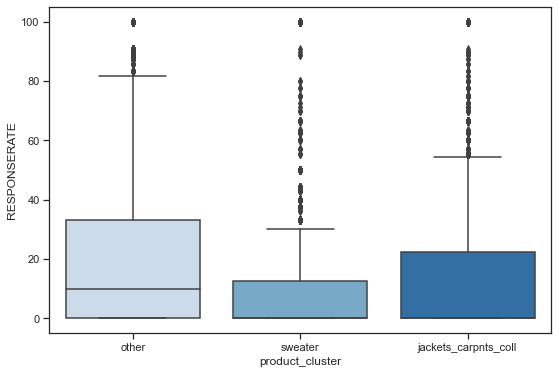

In [86]:
sns.boxplot(data1['product_cluster'],data1['RESPONSERATE'], palette='Blues')

### CHI-SQUARED TEST

In [87]:
from scipy.stats import chi2_contingency

In [88]:
tab=pd.crosstab(data1['product_cluster'],data1['RESP'])
tab

RESP,0,1
product_cluster,,
jackets_carpnts_coll,3827,608
other,11814,2729
sweater,2488,274


In [89]:
chi2_contingency(tab,correction=False)

(164.94423248369532,
 1.5234036972680128e-36,
 2,
 array([[ 3698.34935603,   736.65064397],
        [12127.41706532,  2415.58293468],
        [ 2303.23357866,   458.76642134]]))

### ONE-WAY ANOVA ANALYSIS

In [90]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [91]:
model = smf.ols(formula='RESPONSERATE ~ C(product_cluster)', data=data1) 
reg = model.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           RESPONSERATE   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     240.7
Date:                Fri, 27 May 2022   Prob (F-statistic):          4.09e-104
Time:                        19:45:48   Log-Likelihood:            -1.0019e+05
No. Observations:               21740   AIC:                         2.004e+05
Df Residuals:                   21737   BIC:                         2.004e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        14.3959      0.365     39.491      0.000      13.681      15.110
C(product_cluster)[T.other]       5.2334      0.416     12.567      0.000       4.417       6.050
C(product_cluster)[T.sweater]    -4.8812      0.588     -8.295      0.000      -6.035      -3.728
==============================================================================
Omnibus:                     5425.752   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11125.388
Skew:                           1.499   Prob(JB):                         0.00
Kurtosis:                       4.815   Cond. No.                         5.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
table = sm.stats.anova_lm(reg, typ=3)
print(table)

                          sum_sq       df            F         PR(>F)
Intercept           9.191224e+05      1.0  1559.505522   0.000000e+00
C(product_cluster)  2.837059e+05      2.0   240.686579  4.090265e-104
Residual            1.281109e+07  21737.0          NaN            NaN


ANOVA table

|    Source       |     SS    |   df   | Mean square |    F    |     p-val    |
|-----------------|-----------|--------|-------------|---------|--------------|
| product_cluster | 2.837e+05 |   2    |  141850     | 240.687 | 4.090e-104   |
| Residuals       | 1.281e+05 |  21737 |  397103.786 |         |              |
| Total           | 4.118e+09 |  21739 |             |         |              |  


In [93]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(data1['RESPONSERATE'], data1['product_cluster'])
result = mc.tukeyhsd()
print(result)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
       group1         group2 meandiff p-adj  lower    upper  reject
-------------------------------------------------------------------
jackets_carpnts_coll   other   5.2334 0.001   4.2573  6.2095   True
jackets_carpnts_coll sweater  -4.8812 0.001  -6.2605  -3.502   True
               other sweater -10.1146 0.001 -11.2957 -8.9336   True
-------------------------------------------------------------------


In [95]:
1.281e+05/21737

5.893177531398077